# Nonlinear time series analysis


> "*Something as small as the flutter of a butterfly’s wing can ultimately cause a typhoon halfway around the world.*"

<div style="text-align: right; font-size: 15px;">--Chaos theory</div>

## Overview

In this lecture we will cover the following topics.

- Dynamical systems and nonlinear dynamics.
- Bifurcation diagrams.
- Chaotic systems.
- Higher-dimensional continuous-time systems.
- Phase (state) space of a system.
- Fractal dimensions.
- Phase space reconstruction and Taken's embedding theorem.
- Forecasting nonlinear time series.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.integrate import solve_ivp
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.utils import make_forecasting_dataset

np.random.seed(0)

---

## Dynamical Systems

- A dynamic system is a set of functions (rules, equations) specifying how variables change over time.
- For example:

$$\begin{aligned}x(t+1) &= a \cdot x(t) + b \cdot y(t) \\ y(t+1) &= c \cdot x(t)\end{aligned}$$

- Here, $x$ and $y$ represent the *variables* of a 2-dimensional system, while $a,b,c$ are the *parameters*.

- Variables change over time, parameters do not.
- In a *discrete* system the variables are restricted to integer values.
- In a *continuous* system, variables can assume real values.
- The system can be *stochastic* (one set of rules, many realizations) or *deterministic* (one set of rules, one realization).

- The *state* of a dynamic system at time $t$ is specified by the current value of its variables $x(t), y(t), \dots$
- The process of calculating the new state of a discrete system is called *iteration*.
- To evaluate how a system behaves, we need the functions, the parameter values, and the *initial conditions*, e.g., $x(0), y(0), \dots$

- Let's consider a classic example: the *alpha model*.
- It specifies how $q(t)$, the probability of making an error on trial $t$, changes from one trial to the next:

$$q(t+1) = \beta \cdot q(t)$$

- The new error probability is diminished by $\beta \in (0,1)$.
- Starting from the initial conditions, we iterate the equations of our system and obtain a time series of system states.

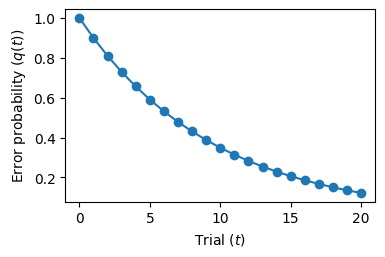

In [4]:
def alpha(beta, q):
    return beta * q # Sytem equation

beta = 0.9          # System parameter
q = [1]             # Initial condition

for _ in range(20):
    q.append(alpha(beta, q[-1])) # Iteration

fig = plt.figure(figsize=(4, 2.5))
plt.plot(q, 'o-')
plt.xlabel('Trial ($t$)')
plt.ylabel('Error probability ($q(t)$)')
plt.show()

---

## Non-linear Dynamical Systems

- Linear systems are those with linear state updates equations, i.e., something of the form $y(t) = a x(t) + b$.
- The alpha model is linear.
- Do not be confused by the non-linear curve we plot above: that is the *behavior* of the system, not the functions that specify its changes.

### The logistic map

- Is a very famous equation to describe the growth of a population.
- Is a non-linear model.
- Is often used to introduce the notion of *chaos*.

- Let's first use a simple linear model to describe the population growth

$$x(t+1) = r x(t)$$

- where $r$ is the growth rate.
- With this model, if $r>1$ the population grows exponentially without limit, which is not very realistic.

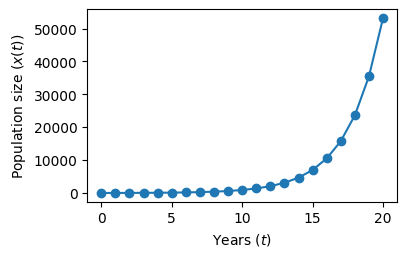

In [5]:
def simple_growth(r, x):
    return r * x

r = 1.5              # Each year x is increased by 50%
x = [16]             # Initial number of individuals
for _ in range(20):
    x.append(simple_growth(r, x[-1]))

fig = plt.figure(figsize=(4, 2.5))
plt.plot(x, 'o-')
plt.xlabel('Years ($t$)')
plt.ylabel('Population size ($x(t)$)')
plt.show()

- The Logistic Map prevents unlimited growth by inhibiting growth whenever it achieves a high level.
- This is achieved by introducing an additional term $[1 - x(t)]$.
- The growth measure $x$ is also rescaled so that the maximum value $x$ can achieve is 1.
- So if the maximum size is 8 billions, $x$ is the proportion of that maximum.

- The new growth model is

$$x(t+1) = r x(t)[1 - x(t)]$$

- with $r \in [0,4]$.
- The $[1-x(t)]$ inhibits the growth because as $x$ approaches 1 (the maximum), $[1-x(t)]$ approaches 0.

In [6]:
def logistic(r, x):
    return r * x * (1 - x)

- Plotting $x(t)$ against $x(t+1)$ shows the nonlinearity of the system.

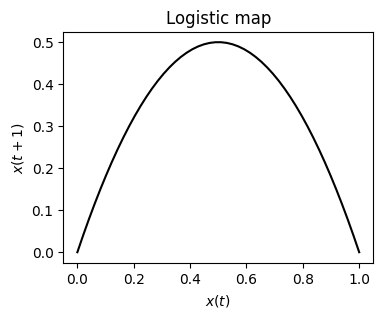

In [7]:
x = np.linspace(0, 1)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(x, logistic(2, x), 'k')
ax.set_title('Logistic map')
ax.set_xlabel('$x(t)$')
ax.set_ylabel('$x(t+1)$')
plt.show()

- To see how it beahaves, we iterate the function and plot the growth.
- It turns out that the logistic map changes drastically its behavior depending the the value of the parameter $r$.
- To see this, we examine the time series of the system's state as $r$ changes from 0 to 1.

In [8]:
def plot_time_series(r, x0, n, color, ax=None):
    t = np.arange(n)
    x = np.empty(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = logistic(r, x[i-1])
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(t, x, 'o-', color=color, alpha=0.5, label=f'$r = {r:.2f}, x(0) = {x0}$')
    ax.set_xlabel('Time step ($t$)')
    ax.set_ylabel('Population size ($x(t)$)')
    ax.legend()

In [9]:
def plot_system(r, x0, n, ax=None):
    # Plot the function and the y=x diagonal line.
    t = np.linspace(0, 1)
    ax.plot(t, logistic(r, t), 'k', lw=2)
    ax.plot([0, 1], [0, 1], 'gray', linestyle='--', lw=2)

    # Recursively apply y=f(x) and plot two lines:
    # (x, x) -> (x, y)
    # (x, y) -> (y, y)
    x = x0
    for _ in range(n):
        y = logistic(r, x)
        # Plot the two lines.
        ax.plot([x, x], [x, y], 'gray', lw=1, alpha=0.5)
        ax.plot([x, y], [y, y], 'gray', lw=1, alpha=0.5)
        # Plot the positions with increasing
        ax.plot([x], [y], 'o', color='tab:blue', ms=10, alpha=0.3)
        x = y

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('$x(t-1)$')
    ax.set_ylabel('$x(t)$')
    ax.set_title(f"$r={r:.2f}, \, x(0)={x0:.1f}$")

<>:24: SyntaxWarning: invalid escape sequence '\,'
<>:24: SyntaxWarning: invalid escape sequence '\,'
C:\Users\A1ex5\AppData\Local\Temp\ipykernel_25392\1243494679.py:24: SyntaxWarning: invalid escape sequence '\,'
  ax.set_title(f"$r={r:.2f}, \, x(0)={x0:.1f}$")


#### Regime $r < 1$

- So long as $r$ is less than 1, the state of the system $x$ will go toward 0.
- This is called *one-point attractor*.

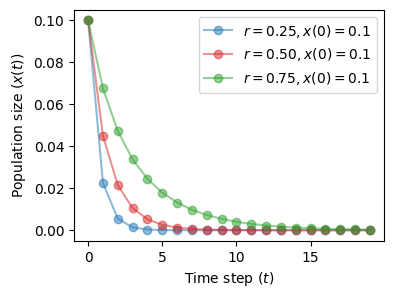

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_time_series(r=0.25, x0=0.1, n=20, color='tab:blue', ax=ax)
plot_time_series(r=0.5, x0=0.1, n=20, color='tab:red', ax=ax)
plot_time_series(r=0.75, x0=0.1, n=20, color='tab:green', ax=ax)

- The situation does not change for different values of the initial condition $x(0)$.
- The initial state is quickly forgotten and the system ends in the same attractor.

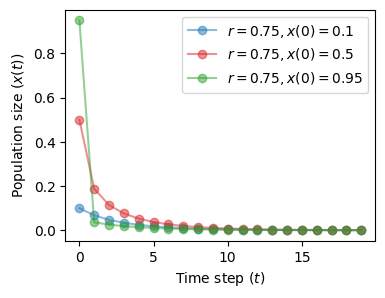

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_time_series(r=0.75, x0=0.1, n=20, color='tab:blue', ax=ax)
plot_time_series(r=0.75, x0=0.5, n=20, color='tab:red', ax=ax)
plot_time_series(r=0.75, x0=0.95, n=20, color='tab:green', ax=ax)

- We can also see how the current state $x(t)$ relates to the previous state $x(t-1)$.

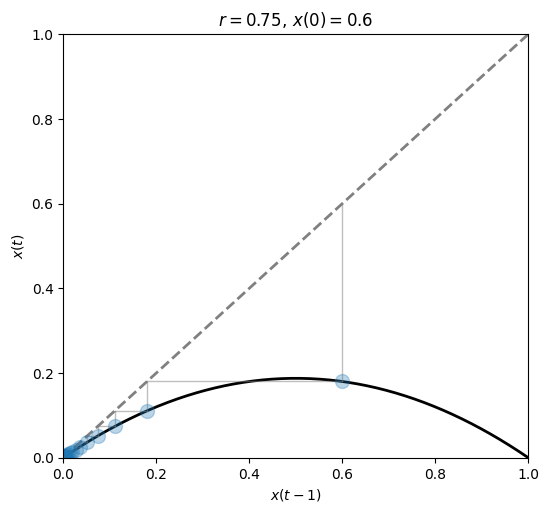

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
plot_system(r=0.75, x0=.6, n=20, ax=ax)

#### Regime $1 < r < 3$

- We still have a one-point attractor, but now it changes with the value of $r$.

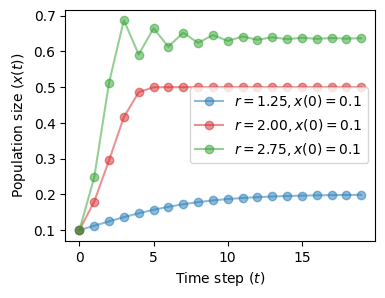

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_time_series(r=1.25, x0=0.1, n=20, color='tab:blue', ax=ax)
plot_time_series(r=2.0, x0=0.1, n=20, color='tab:red', ax=ax)
plot_time_series(r=2.75, x0=0.1, n=20, color='tab:green', ax=ax)

- As before, the initial state is inconsequential and its effect is washed-out eventually.

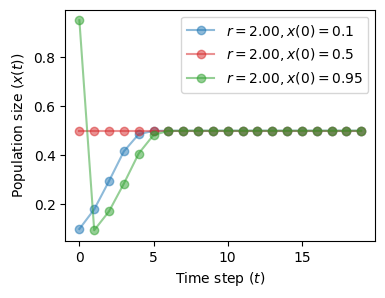

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_time_series(r=2.0, x0=0.1, n=20, color='tab:blue', ax=ax)
plot_time_series(r=2.0, x0=0.5, n=20, color='tab:red', ax=ax)
plot_time_series(r=2.0, x0=0.95, n=20, color='tab:green', ax=ax)

- As we get closer to $r=3$ the state oscillates more and more before settling down to its attractor.
- The behavior is best observed by looking at the state-vs-state plot.

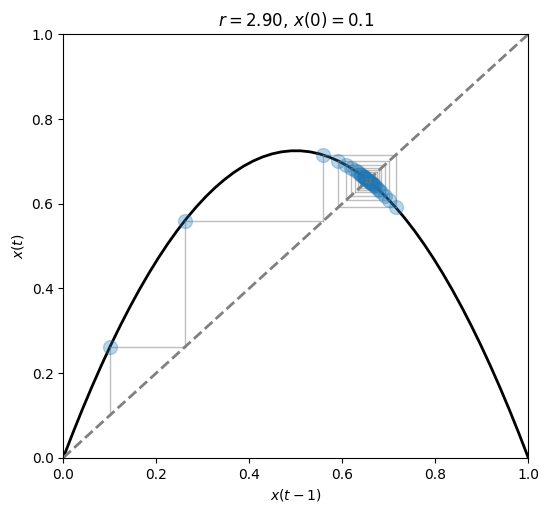

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
plot_system(r=2.9, x0=.1, n=30, ax=ax)

#### Regime $r > 3$

- As soon as we move beyond $r=3$ the system starts oscillating between two points.
- We have a two-point attractor.
- The phenomenon we observe is called *bifurcation*, or *period-doubling*.

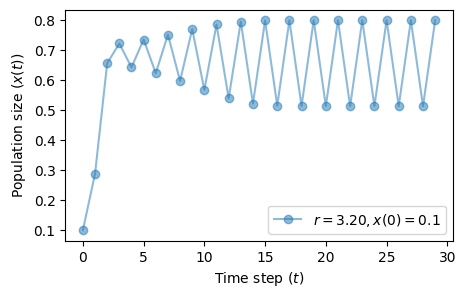

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_time_series(r=3.2, x0=0.1, n=30, color='tab:blue', ax=ax)

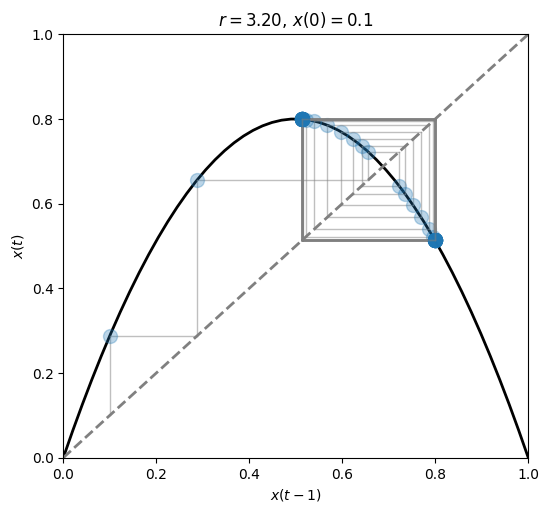

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
plot_system(r=3.2, x0=.1, n=60, ax=ax)

- At $r=3.54$ another bifurcation occurs.
- We have now reached a 4-point attractor.

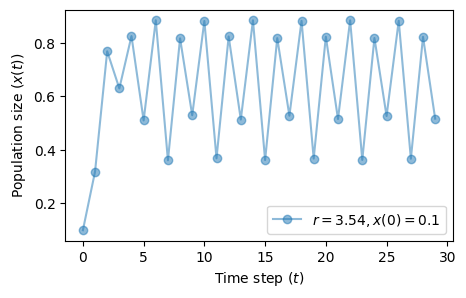

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_time_series(r=3.54, x0=0.1, n=30, color='tab:blue', ax=ax)

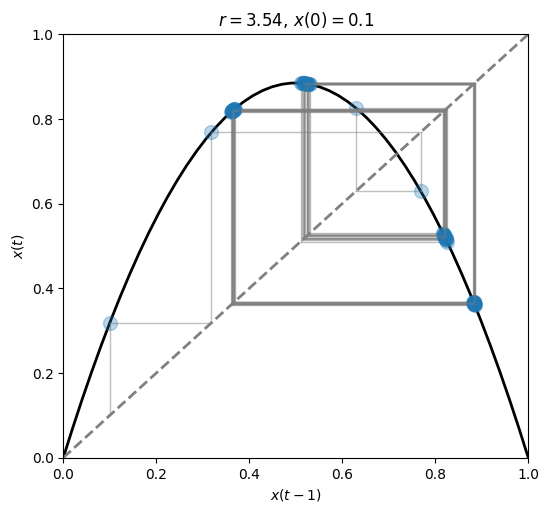

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
plot_system(r=3.54, x0=.1, n=60, ax=ax)

- The number of bifurcations keep growing as we increase $r$.
- Eventually, we witstand the so-called *N-point attractor*.
- The system settles down to an attractor that looks "unstable" or "strange".
- This a characterizing property of *chaotic systems*.

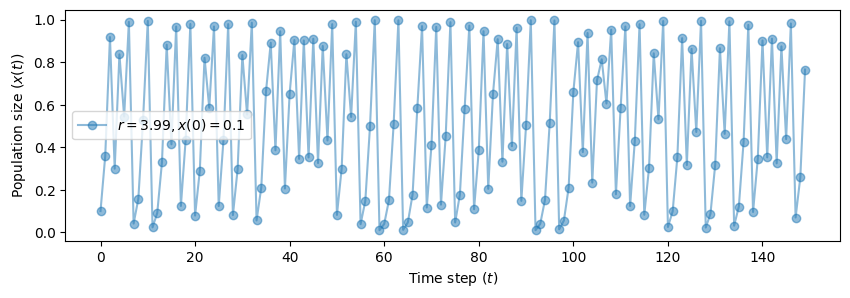

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_time_series(r=3.99, x0=0.1, n=150, color='tab:blue', ax=ax)

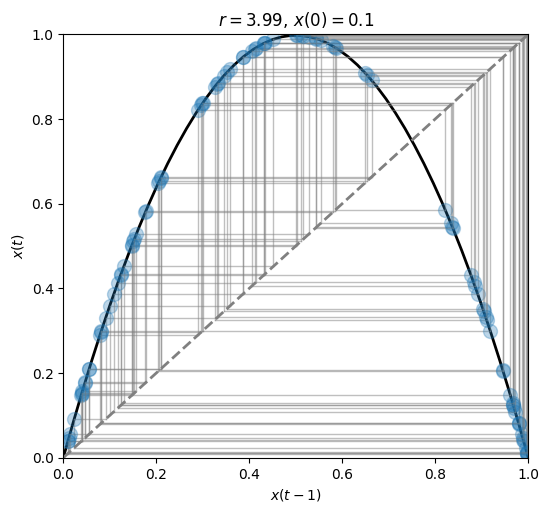

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
plot_system(r=3.99, x0=.1, n=100, ax=ax)

### Bifurcation diagrams

- As we said, a bifucation is a period-doubling, i.e., a change from an $N$-point attractor to a $2N$-point attractor.
- In the Logistic map, it occurs when the control parameter ($r$) is changed.
- A *bifurcation diagram* is a visual summary of the succession of period-doubling produced as the control parameter changes.

- Let's compute the bifurcation diagram of the logistic map.
- On the x-axis, we have the value of $r$.
- On the y-axis, we have the number of distinct points the system settles down to.

In [22]:
def bifuracion_diagram(r, ax, iterations=1000, last=100):
    x = 1e-5 * np.ones_like(r)
    for i in range(iterations):
        x = logistic(r, x)
        if i >= (iterations - last): # plot only the 'last' last iterations
            ax.plot(r, x, ',k', alpha=.25)
    ax.set_title("Bifurcation diagram")
    ax.set_xlabel("$r$")
    ax.set_ylabel("$x$")

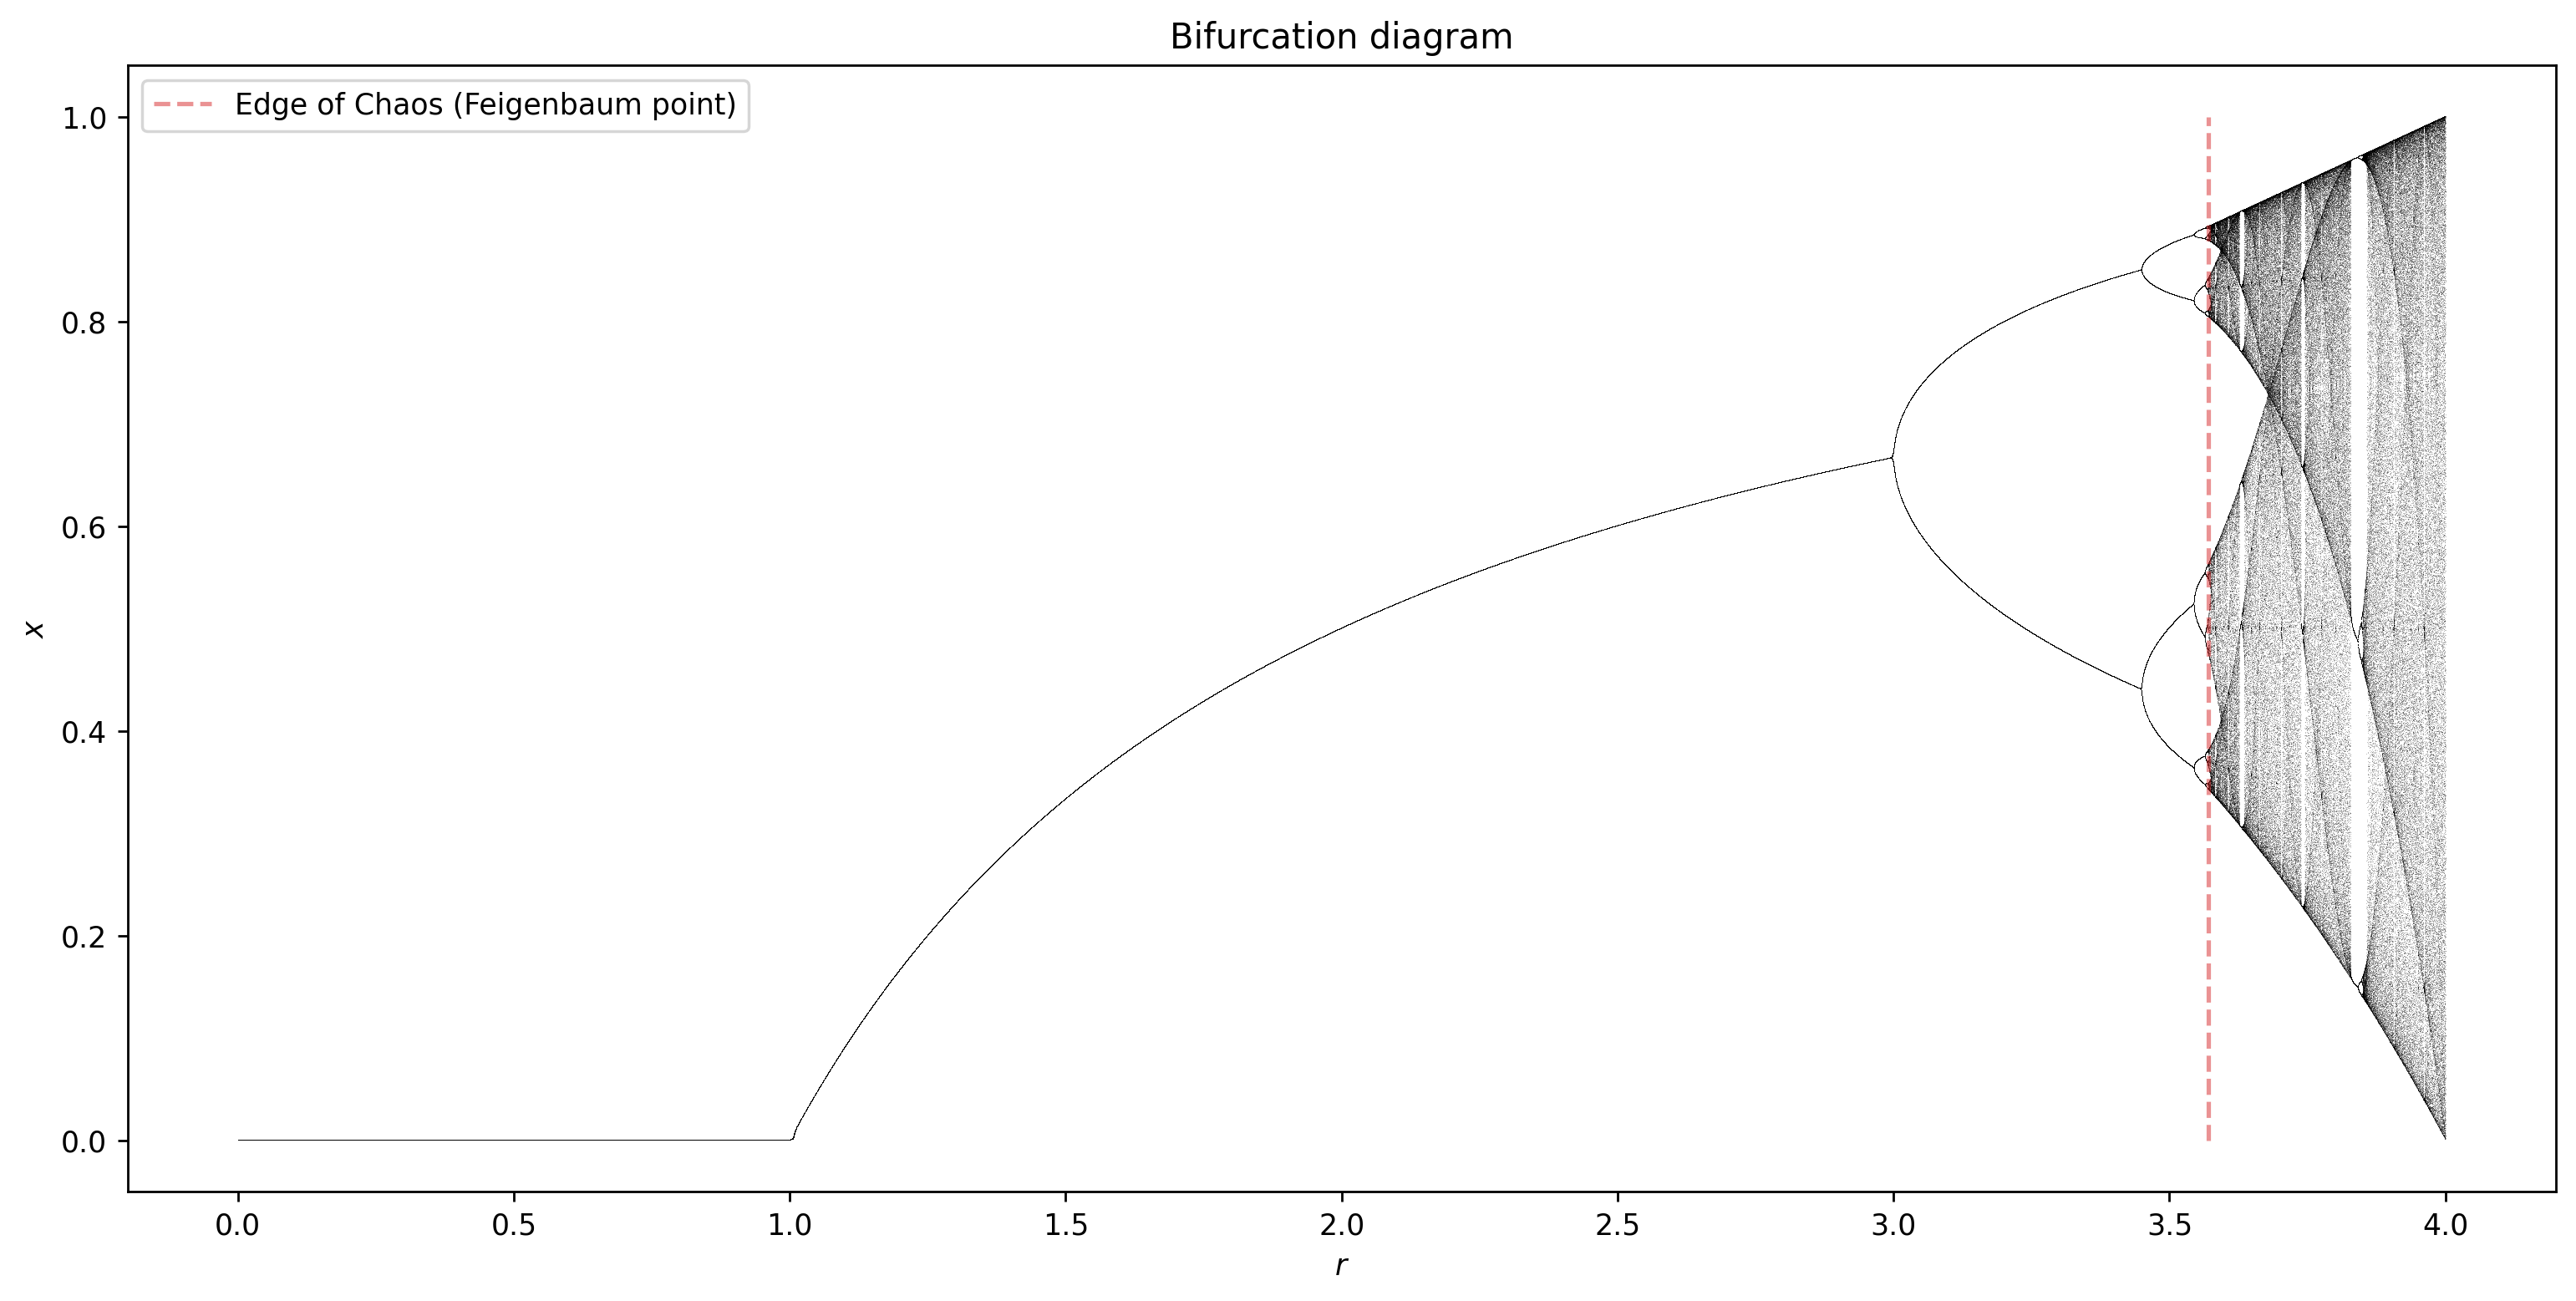

In [23]:
r = np.linspace(0, 4.0, 30000)

fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=250)
bifuracion_diagram(r, ax)
ax.vlines(3.569945, 0, 1, 'tab:red', linestyles='--', alpha=0.5, label='Edge of Chaos (Feigenbaum point)')
plt.legend()
plt.show()

- Мы видим, что при $r<1$ ноль является одноточечным аттрактором. 
- Для $1<r<3$ у нас все еще есть одноточечные аттракторы, но «притягиваемое» значение $x$ увеличивается с увеличением $r$. 
- Бифуркации происходят при $r=3$, $r=3,45$, $3,54$, $3,564$, $3,569$ и т. д. 
- Примерно при $r=3.57$ наша система становится хаотичной. 
- Однако система не является хаотичной для всех значений $r$, больших 3,57.

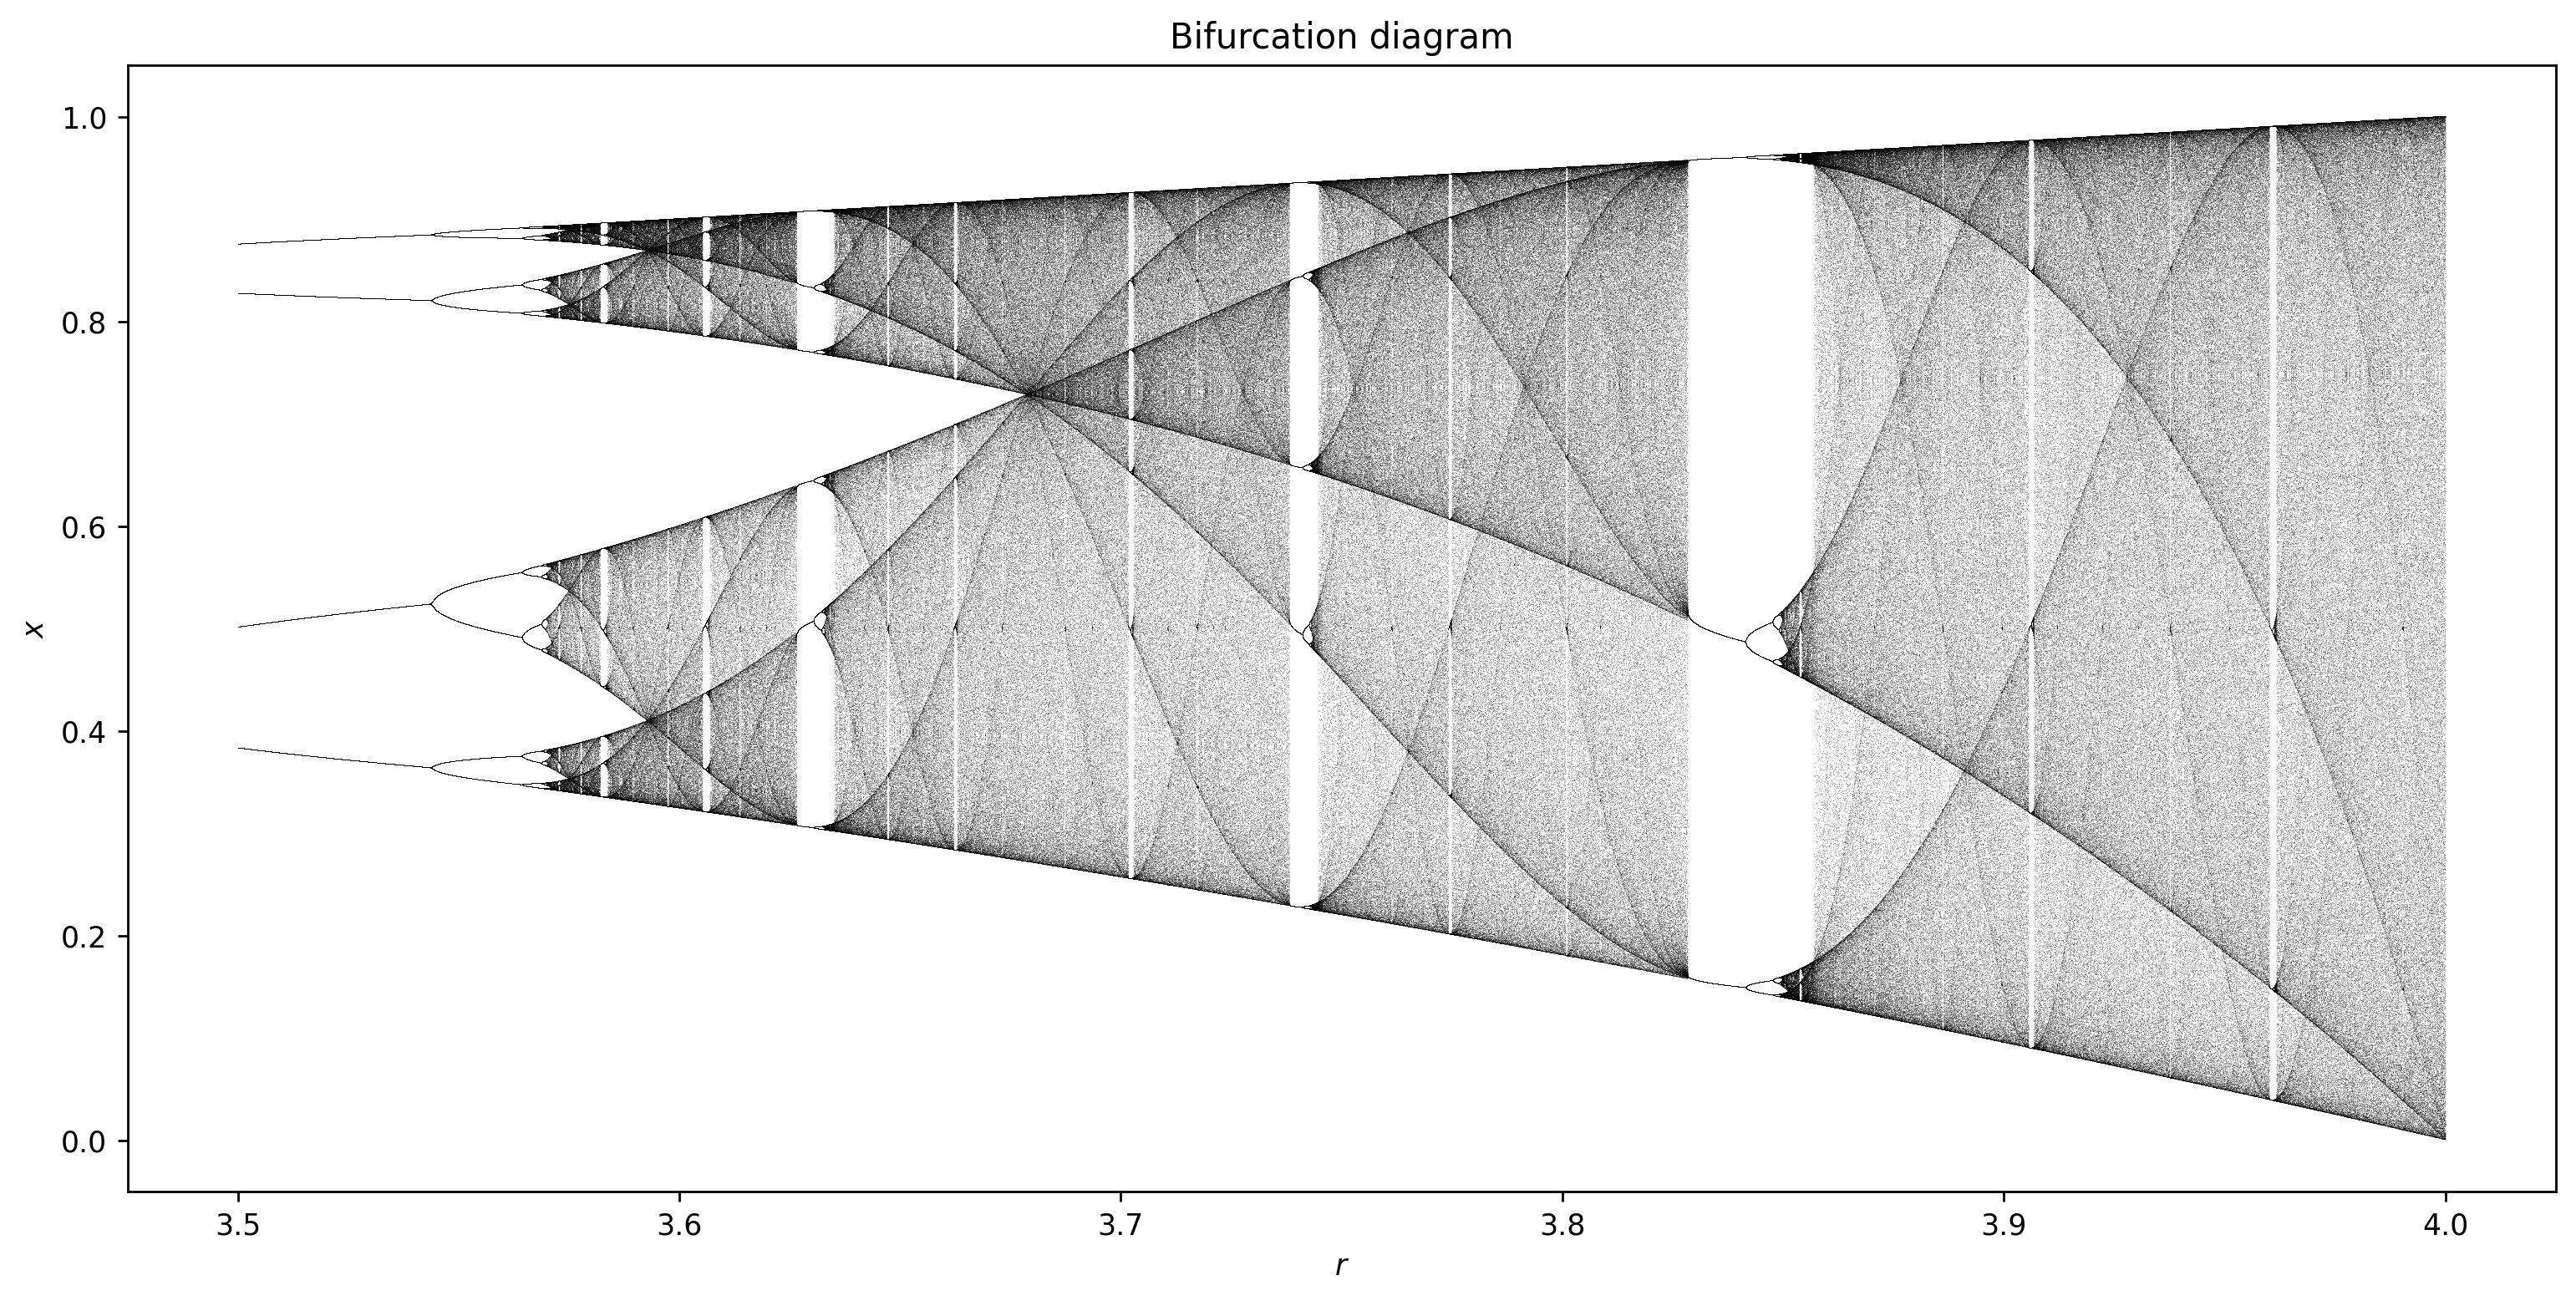

In [24]:
n = 30000 # number of values of r
r = np.linspace(3.5, 4.0, n)

fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=250)
bifuracion_diagram(r, ax)
plt.show()

- При нескольких значениях $r > 3,57$ существуют области, в которых посещается небольшое количество значений $x$. 
- Эти области создают на диаграмме пустые места. 
- Например, при $r=3,83$ существует трёхточечный аттрактор. 
- Между 3.57 и 4 происходит богатое чередование хаоса и порядка. 
- Небольшое изменение $r$ может сделать стабильную систему хаотичной, и наоборот. 

---

## Chaotic systems

- Многие явления реального мира хаотичны, особенно те, которые включают нелинейное взаимодействие между многими агентами (сложными системами). 
- Примеры можно найти в метеорологии, экономике, биологии и других дисциплинах. 
- Далее мы рассмотрим некоторые известные хаотические системы и их свойства.

### Чувствительность к начальным условиям 

- Характерной особенностью хаотических систем является их чувствительность к начальным условиям. 
- Давайте посмотрим на Логистическую карту для $r=3,99$. 
- Мы начнем с двух очень близких начальных условий: $x(0)=0.1$ и $x(0)=0.101$.

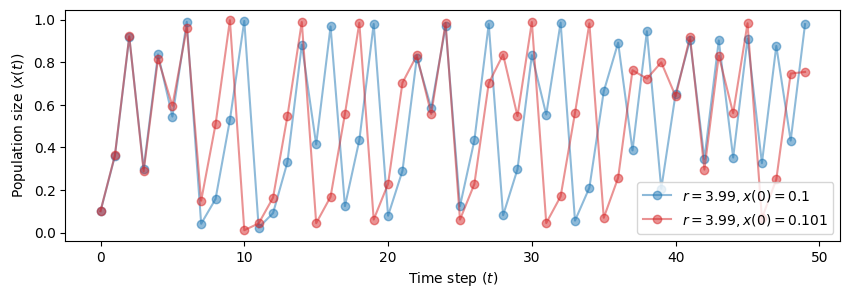

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_time_series(r=3.99, x0=0.1, n=50, color='tab:blue', ax=ax)
plot_time_series(r=3.99, x0=0.101, n=50, color='tab:red', ax=ax)

- Чтобы две траектории разошлись, нужно совсем немного шагов. 
- Что если мы возьмем начальные условия *действительно* близко?

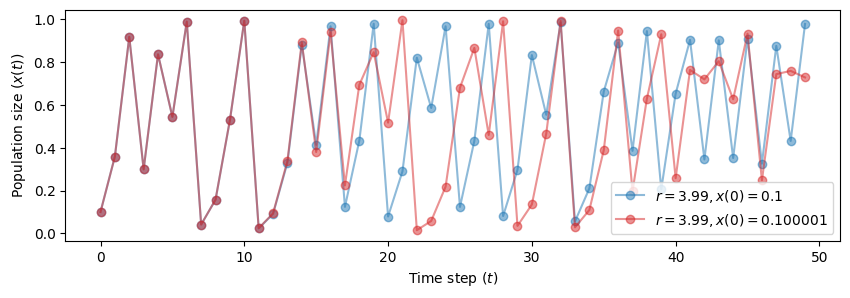

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_time_series(r=3.99, x0=0.1, n=50, color='tab:blue', ax=ax)
plot_time_series(r=3.99, x0=0.100001, n=50, color='tab:red', ax=ax)

- Пример должен прояснить этот момент: 
> В хаотической системе, какими бы близкими ни были начальные условия, если они различны, траектории в конечном итоге разойдутся. 
- С другой стороны, система никогда не забудет свое первоначальное состояние.

### Обнаружение хаоса 

- Как определить, имеет ли система сжимающую или хаотическую динамику? 
- У нас есть несколько инструментов. 
- Один из них — измерить чувствительность к начальным условиям, которые, как мы знаем, высоки для хаотической системы. 
- Для этого можно использовать *показатель Ляпунова*.

####показатель Ляпунова 

- Показатель Ляпунова количественно определяет скорость, с которой ближайшие траектории в системе расходятся или сходятся с течением времени. 
— Оно говорит нам, насколько чувствительна система к своим начальным условиям — свойство, часто связанное с хаотичным поведением. 
- На самом деле для данной системы существует несколько показателей Ляпунова, соответствующих различным направлениям в фазовом пространстве системы. 
- *Самый большой* показатель Ляпунова чаще всего используется для обнаружения хаоса. 
- Система считается хаотичной, если она имеет хотя бы один *положительный* показатель Ляпунова.

**Определение** 

- Пусть динамическая система определяется как 

$\dot{x} = f(x, t)$ 

- где: 
   - $\dot{x}$ представляет собой производную по времени от $x$, 
   - $f(x, t)$ — функция, определяющая эволюцию системы во времени.

- Рассмотрим две близлежащие точки фазового пространства системы $x_0$ и $x_0 + \delta x_0$, где $\delta x_0$ — малое возмущение. 
- Их траектории со временем расходятся в соответствии с 

$\delta x(t) \approx \delta x_0 e^{\lambda t}$ 

- где: 
   - $\delta x(t)$ — расстояние между двумя траекториями в момент времени $t$, 
   - $\lambda$ — показатель Ляпунова.

- Показатель рассчитывается как

$$\lambda = \lim_{t \to \infty} \lim_{|\delta x_0| \to 0} \frac{1}{t} \ln \left( \frac{|\delta x(t)|}{|\delta x_0|} \right)$$

- Этот предел, если он существует, дает среднюю скорость экспоненциальной расходимости (если $\lambda > 0$) или сходимости (если $\lambda < 0$) траекторий, начинающихся с бесконечно близких начальных условий. 
- Показатель степени часто можно вычислить аналитически. 
- В противном случае оно рассчитывается численно путем наблюдения за тем, как небольшие возмущения развиваются с течением времени.

- Положительный показатель Ляпунова означает, что небольшие различия в начальных условиях приводят к экспоненциальному расхождению траекторий. 
- Это очень затрудняет долгосрочные прогнозы, несмотря на то, что система является детерминированной. 
- Эту чувствительность к начальным условиям часто называют «эффектом бабочки» в контексте теории хаоса.

- Далее мы создаем функцию для построения показателя Ляпунова на логистической карте при увеличении $r$. 
- Мы раскрасим красным значения $r$, связанные с $\lambda>0$, что указывает на хаотическое поведение системы. 
— Чтобы проверить, работает ли показатель Ляпунова как детектор хаоса, сравним его с картой бифуркации.

In [27]:
def lyapunov(r, ax, iterations=1000):
    x = 1e-5 * np.ones_like(r)
    lyapunov = np.zeros_like(r)
    for i in range(iterations):
        x = logistic(r, x)
        lyapunov += np.log(abs(r - 2 * r * x)) # Partial sum of the Lyapunov exponent.

    ax.axhline(0, color='k', lw=.5, alpha=.5)

    # Negative Lyapunov exponent.
    ax.plot(r[lyapunov < 0],
            lyapunov[lyapunov < 0] / iterations,
            '.k', alpha=.5, ms=.5)

    # Positive Lyapunov exponent.
    ax.plot(r[lyapunov >= 0],
            lyapunov[lyapunov >= 0] / iterations,
            '.', color='tab:red', alpha=.5, ms=.5)
    ax.set_ylim(-2, 1)
    ax.set_title("Lyapunov exponent")

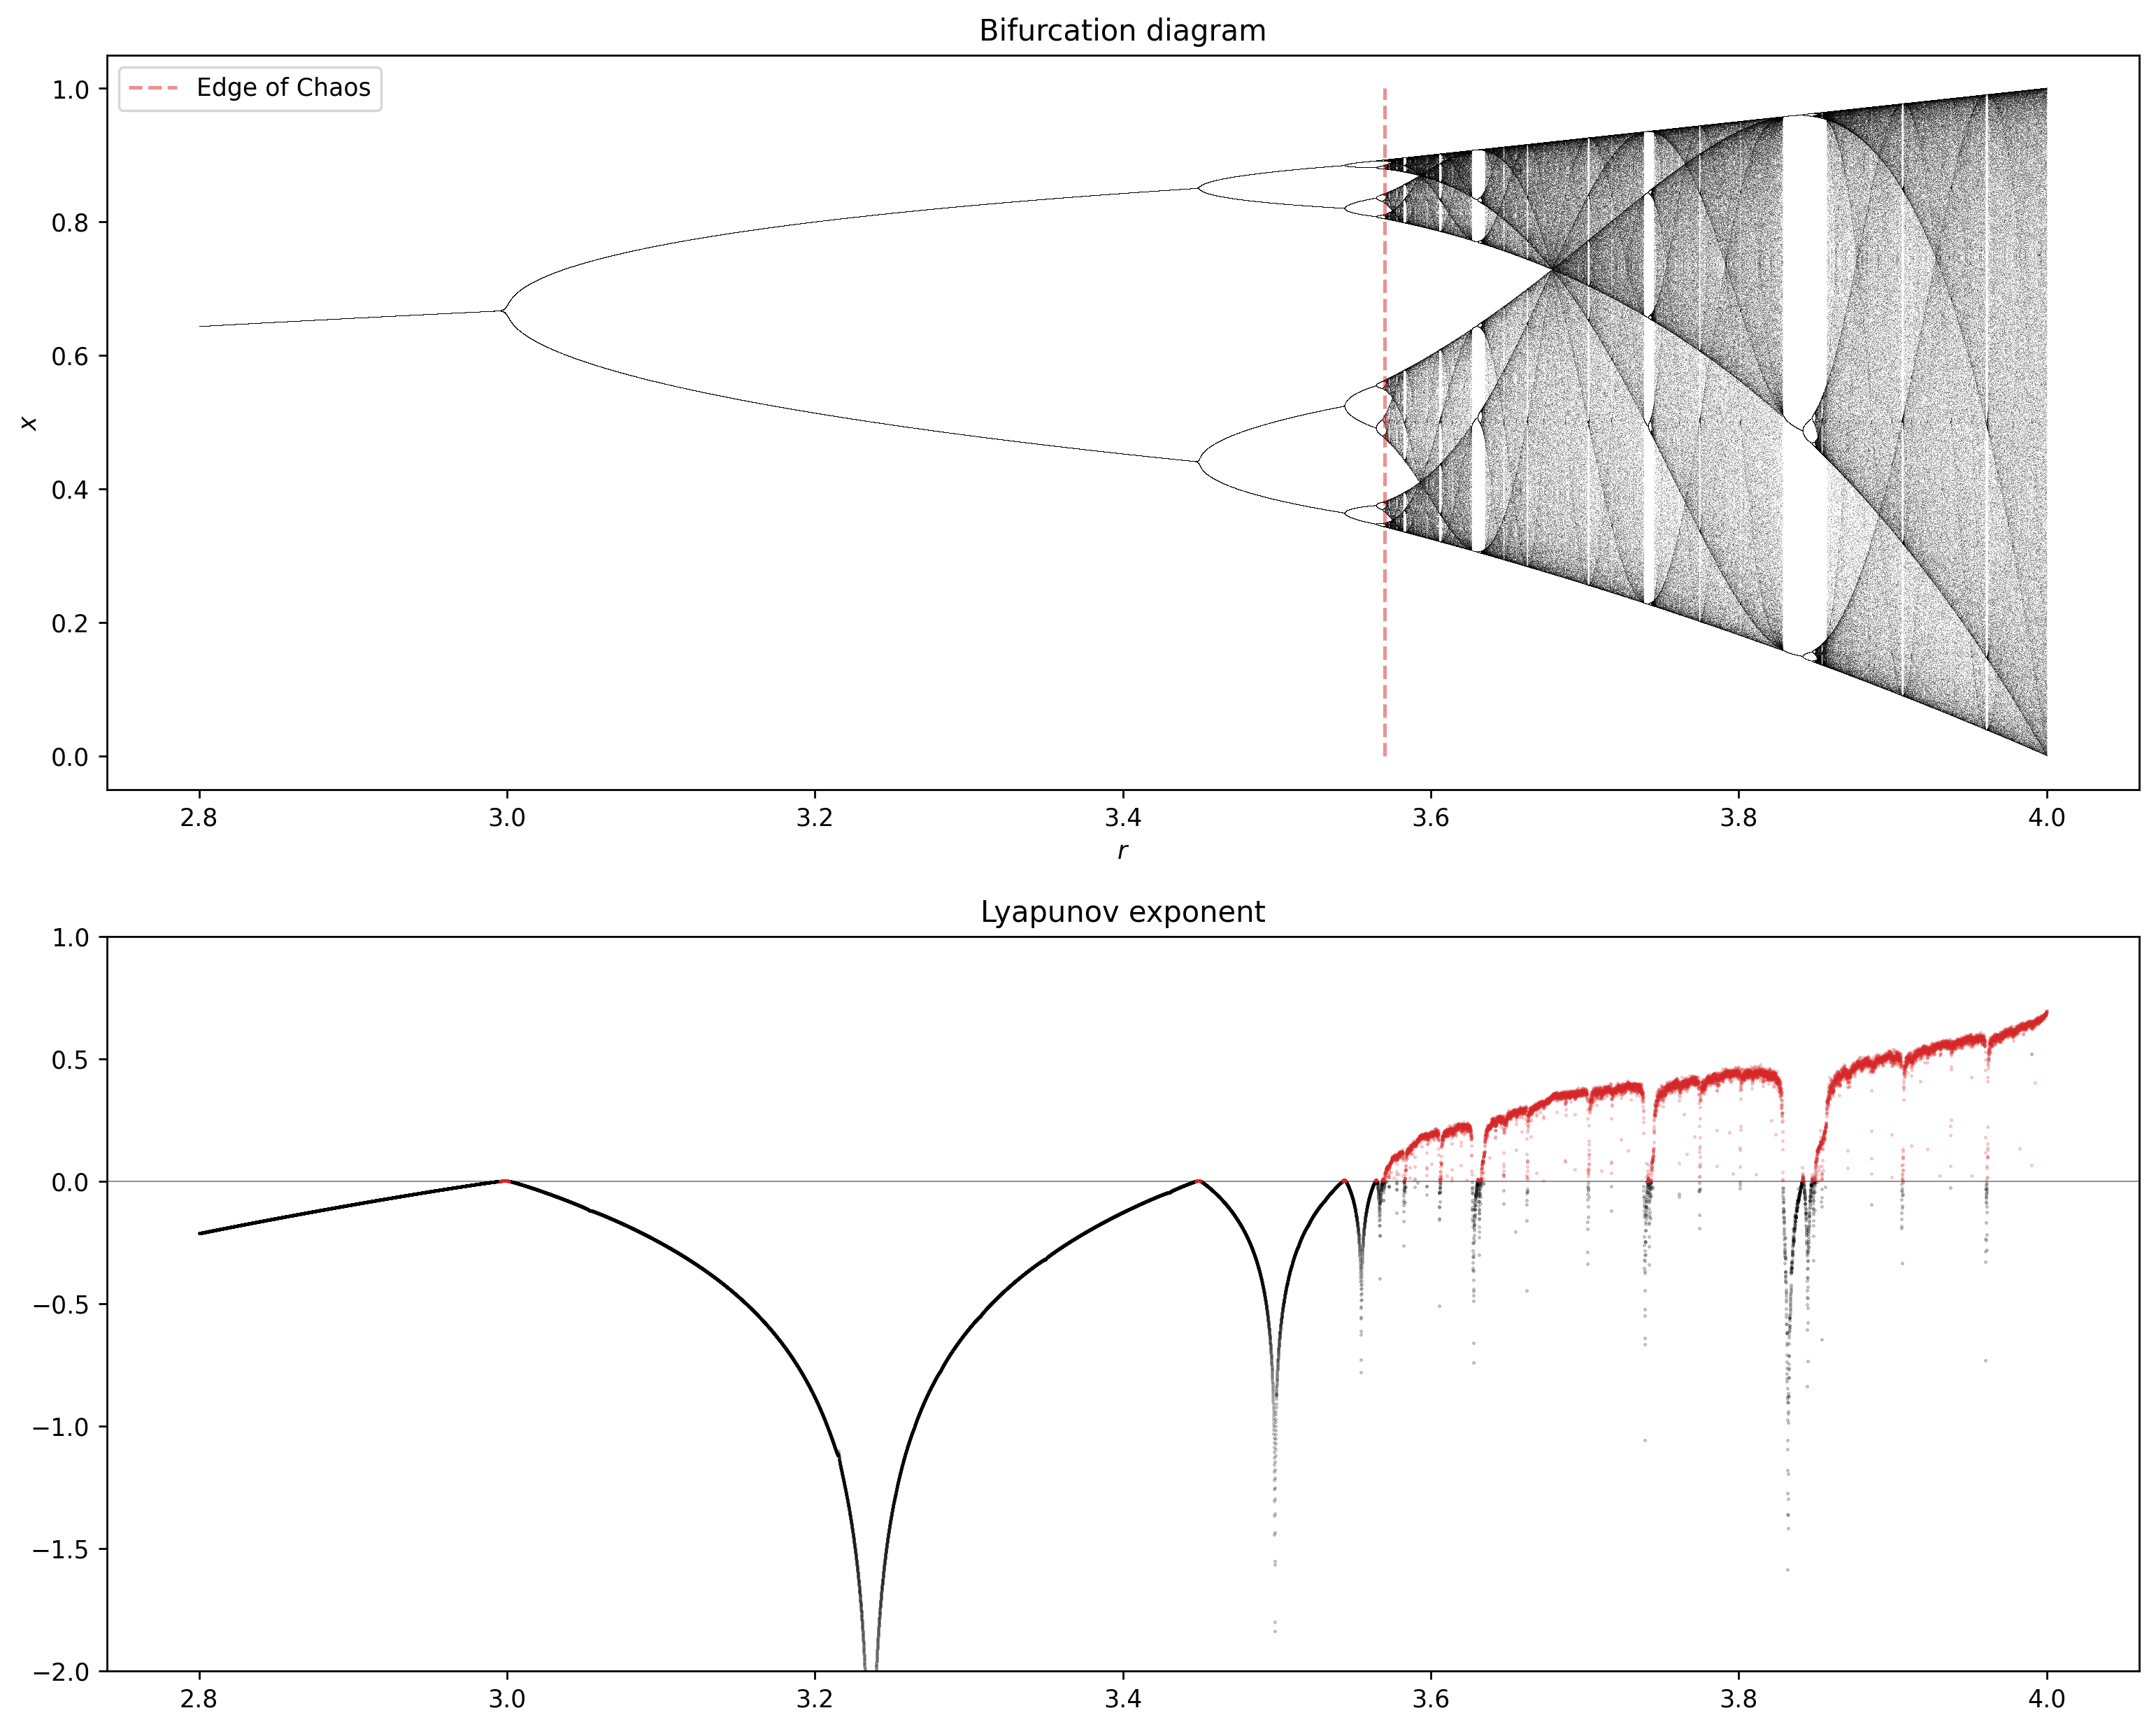

In [28]:
r = np.linspace(2.8, 4.0, 30000)

fig, axes = plt.subplots(2, 1, figsize=(15, 12), dpi=250)
bifuracion_diagram(r, axes[0])
axes[0].vlines(3.569945, 0, 1, 'tab:red', linestyles='--', alpha=0.5, label='Edge of Chaos')
axes[0].legend()
lyapunov(r, axes[1])
plt.show()

#### Возврат карт 

- Еще одно важное различие – между хаосом и случайностью. 
- На первый взгляд хаотические и случайные процессы очень похожи. 
- Давайте рассмотрим временной ряд выборок, сгенерированных: 
   - равномерное распределение, 
   - нормальное распределение, 
   - Логистическая карта за $r=3,99$.

In [ ]:
uniform_data = np.random.uniform(low=0, high=1, size=300) # Random uniform

normal_data = np.random.randn(300) # Random normal

lgt_data = np.empty(300) # Logistic map
lgt_data[0] = 0.1
for i in range(1, len(lgt_data)):
    lgt_data[i] = logistic(3.99, lgt_data[i-1])

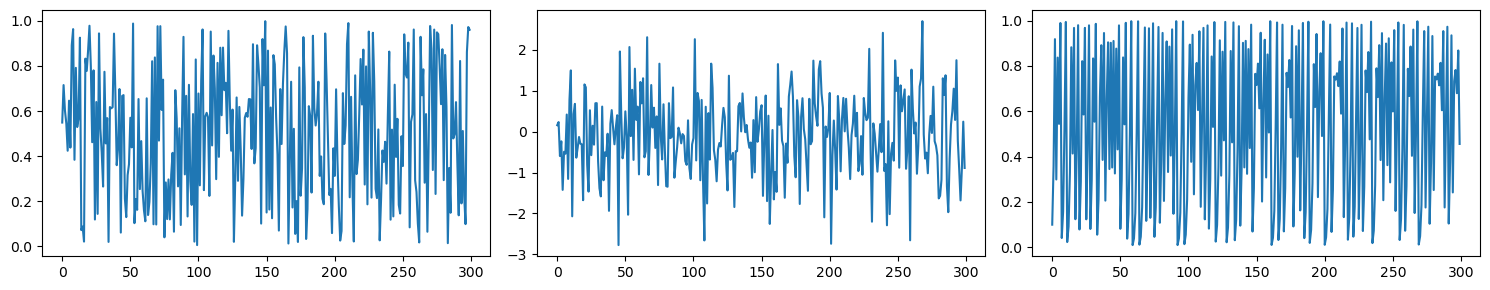

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15, 3))
axes[0].plot(uniform_data)
axes[1].plot(normal_data)
axes[2].plot(lgt_data)
plt.tight_layout()
plt.show()

- Как мы определяем, является ли система хаотичной или случайной? 
- И в этом случае в нашем распоряжении есть несколько инструментов. 
- Одно из них — *карта возвращения*.

- Карту возвращения мы уже видели. 
- Он просто заключается в построении графика текущего значения $x(t)$ против следующего $x(t+1)$. 
- Если временной ряд случайный, мы не увидим структуры или не увидим ее, поскольку следующее значение не коррелирует с текущим. 
- Вместо этого, если временной ряд хаотичен, мы увидим четко определенную структуру.

In [ ]:
def return_map(series, ax, title):
    ax.plot(series[:-1], series[1:], 'o', alpha=0.2)
    ax.set_xlabel('$x(t)$')
    ax.set_ylabel('$x(t+1)$')
    ax.set_title(title)

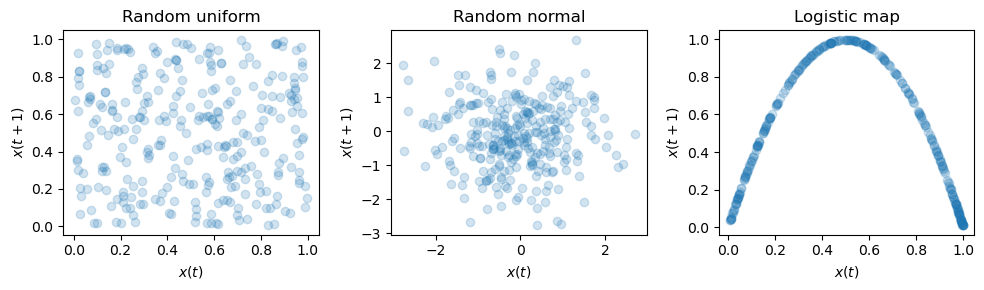

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(10, 3))
return_map(uniform_data, axes[0], "Random uniform")
return_map(normal_data, axes[1], "Random normal")
return_map(lgt_data, axes[2], "Logistic map")
plt.tight_layout()
plt.show()

---

## Higher-dimensional continous-time systems

- В случае с Логистической картой в системе была только одна переменная: $x(t)$. 
— В общем, у нас могут быть системы с двумя и более переменными. 
- Количество переменных определяет *размерность* системы. 
- *Состояние* системы — это текущие значения ее переменных.

- Большая часть наблюдаемых нами временных рядов возникла из систем *дискретного* времени, которые развиваются через определенные промежутки времени. 
- Временная переменная $t$ принимает значения из дискретного набора, часто целые числа, обозначающие отдельные временные шаги или периоды. 
- Динамика дискретных систем описывается с помощью *разностных уравнений*, например,

$$x(t+1) = f(x(t))$$

- Системы дискретного времени широко распространены в цифровой обработке сигналов, компьютерных алгоритмах, экономических моделях и в любом контексте, где наблюдения или изменения происходят через четко определенные интервалы времени.

- В системах *непрерывного* времени переменная времени $t$ может принимать любое значение в диапазоне действительных чисел. 
— Это означает, что состояние системы может измениться в любой момент времени. 
- Динамика систем с непрерывным временем описывается с помощью *дифференциальных уравнений*, которые моделируют, как переменные состояния изменяются по отношению к непрерывному времени, например,

$$\frac{dx}{dt} = f(x)$$

- Многие физические и природные процессы моделируются как системы с непрерывным временем, такие как движение планет, электрические цепи и гидродинамика.

### 2D - уравнения Лотки-Вольтерра 

- Уравнения Лотки-Вольтерра используются для моделирования популяционной системы хищник-жертва. 
- Он расширяет логистическую карту, моделируя взаимодействие между двумя видами: хищником и его добычей. 
- На рост двух видов влияет присутствие других особей. 
- Логистическая карта представляет собой одномерную модель с дискретным временем, представленную одним уравнением. 
- Модель хищник-жертва представляет собой двумерную систему, работающую в непрерывном времени.

Уравнения Лотки-Вольтерра для динамики хищник-жертва имеют вид:

\begin{align*}
\frac{dx}{dt} &= \alpha x - \beta xy \\
\frac{dy}{dt} &= \delta xy - \gamma y
\end{align*}

- $x$ — популяция жертв, 
- $y$ – популяция хищников, 
- $\frac{dx}{dt}$ и $\frac{dy}{dt}$ — скорость изменения популяций жертв и хищников с течением времени соответственно, 
- $\alpha$ — естественная скорость роста добычи в отсутствие хищников, 
- $\beta$ — смертность жертвы от хищников, 
- $\delta$ — эффективность превращения съеденной добычи в потомство хищника, 
- $\gamma$ – естественная смертность хищников при отсутствии пищи (добычи).

- Эта система может демонстрировать разнообразную динамику, включая стабильные предельные циклы, когда популяции хищников и жертв колеблются регулярным, периодическим образом. 
- Аттрактор в системе Лотка-Вольтерра в данном случае обычно представляет собой замкнутый контур, отражающий циклический характер взаимодействий хищник-жертва.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/lokta_volt.png?raw=1" style="width: 40%; display: block; margin: auto;">

- Определим систему дифференциальных уравнений. 
- Чтобы «запустить» систему, мы используем числовой решатель `scipy.integrate.solve_ivp`. 
- Поскольку решатель принимает одну переменную состояния, мы определяем `z = [x, y]`. 
- Обратите внимание, что переменная `t` не используется в определяемой нами функции.но это нужно решателю.

In [ ]:
# Lotka-Volterra equations
def lotka_volterra(t, z, alpha, beta, delta, gamma):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

- Для следующих графиков мы будем использовать функцию lokta_volterra_attractor, которая: 
    - Запускает решатель, вычисляющий последовательность состояний во времени. 
    - Строит временные ряды переменных состояния. 
    - Строит аттрактор.
- Обратите внимание на синтаксис solve_ivp: все параметры системы передаются через аргумент args. Дополнительная информация [здесь] (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

In [ ]:
def lokta_volterra_attractor(z0, t,
                             alpha=2, beta=1.25, gamma=1.5, delta=0.75,
                             ax1=None, ax2=None):

    # Solve the differential equations
    sol = solve_ivp(lotka_volterra, [t.min(), t.max()], z0,
        args=(alpha, beta, delta, gamma), t_eval=t)

    if ax1 is not None:
        # Plot the time series
        ax1.plot(sol.t, sol.y[0], label='Prey $x(t)$')
        ax1.plot(sol.t, sol.y[1], label='Predator $y(t)$')
        ax1.set_title('System variables')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Population')
        ax1.legend()

    if ax2 is not None:
        # Plot attractor
        ax2.plot(sol.y[0], sol.y[1], label=f'$z(0) = {z0}$', alpha=0.5, linewidth=0.3)
        ax2.set_title('Attractor')
        ax2.set_xlabel('Prey Population')
        ax2.set_ylabel('Predator Population')
        ax2.legend()

- При заданном наборе параметров система демонстрирует хаотичное поведение.

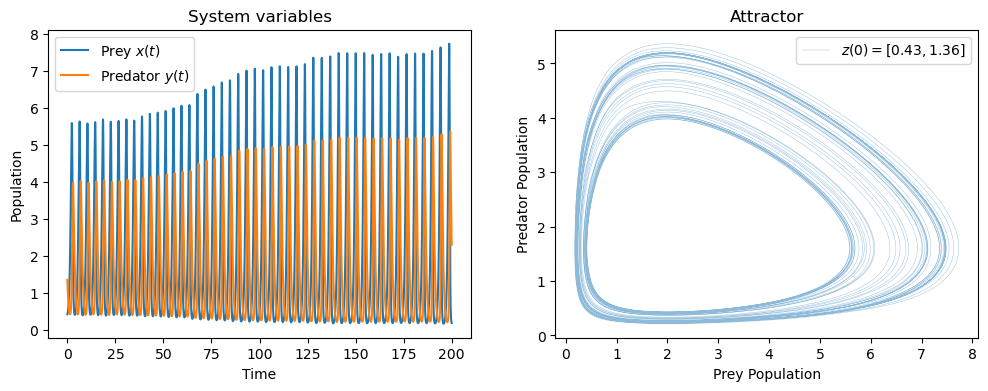

In [ ]:
t = np.linspace(0, 200, 10000)
_, axes = plt.subplots(1, 2, figsize=(12,4))
z0 = [0.43, 1.36]
lokta_volterra_attractor(z0, t, ax1=axes[0], ax2=axes[1])

— Действительно, система в такой конфигурации очень чувствительна к различным начальным условиям.

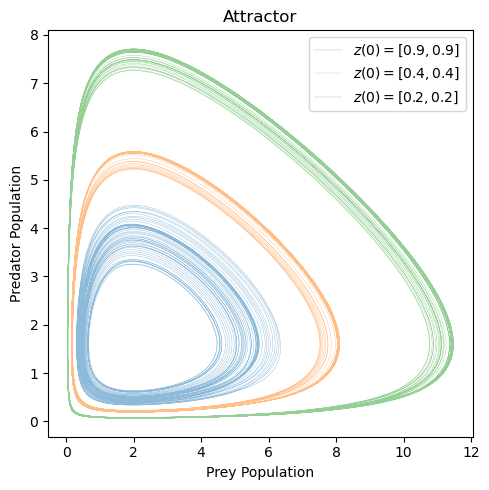

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

z0 = [0.9, 0.9]
lokta_volterra_attractor(z0, t, ax2=ax)

z0 = [0.4, 0.4]
lokta_volterra_attractor(z0, t, ax2=ax)

z0 = [0.2, 0.2]
lokta_volterra_attractor(z0, t, ax2=ax)

plt.tight_layout()
plt.show()

### Система Рёсслера 

- Система Ресслера отличается хаотичным поведением, которое возникает из простого набора нелинейных обыкновенных дифференциальных уравнений (ОДУ).

\begin{align*}
\frac{dx}{dt} &= -y - z, \\
\frac{dy}{dt} &= x + ay, \\
\frac{dz}{dt} &= b + z(x - c),
\end{align*}

- $x$, $y$ и $z$ — состояния системы во времени $t$, а $a$, $b$ и $c$ — параметры, определяющие поведение системы. 
- Типичными значениями, приводящими к хаотическому поведению, являются $a = 0,2$, $b = 0,2$ и $c = 5,7$, хотя хаос можно наблюдать и для других значений.

In [ ]:
# Define the Rössler attractor system of equations
def rossler_system(t, y, a, b, c):
    x, y, z = y
    dxdt = -y - z
    dydt = x + a*y
    dzdt = b + z*(x - c)
    return [dxdt, dydt, dzdt]

In [ ]:
# Parameters
a, b, c = 0.2, 0.2, 5.7
y0 = [0.0, 2.0, 0.0]  # Initial conditions
T = 500 # Final time
t_span = [0, T]  # Time span for the integration

# Solve the differential equations
solution = solve_ivp(rossler_system, t_span, y0, args=(a, b, c), dense_output=True)
t = np.linspace(0, T, int(5e4))
ross_sol = solution.sol(t)

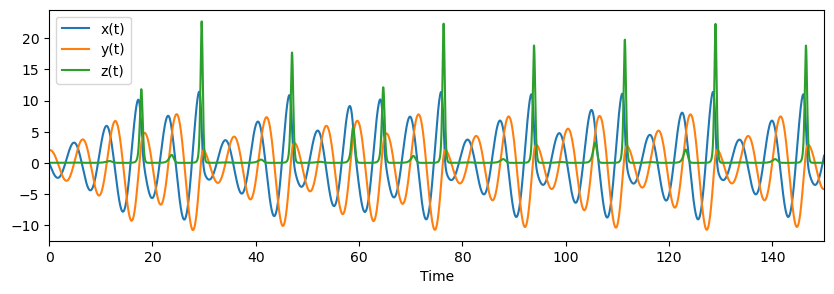

In [ ]:
# Plot time series
fig, ax = plt.subplots(1,1,figsize=(10, 3)  )
ax.plot(t, ross_sol[0], label="x(t)")
ax.plot(t, ross_sol[1], label="y(t)")
ax.plot(t, ross_sol[2], label="z(t)")
ax.set_xlabel("Time")
ax.set_xlim(0, 150)
plt.legend()
plt.show()

In [ ]:
def plot_attractor(data, title="", interactive=False):
    xt, yt, zt = data[0], data[1], data[2]
    if interactive:
        fig = go.Figure(data=[go.Scatter3d(x=xt, y=yt, z=zt, mode='lines', line=dict(color='black', width=1))])
        fig.update_layout(title=title, scene=dict(xaxis_title='x(t)', yaxis_title='y(t)', zaxis_title='z(t)'),
                          autosize=False, width=800, height=600, margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
    else:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(xt, yt, zt, linewidth=0.2, alpha=0.7, color='k')
        ax.set_title(title)
        plt.show()

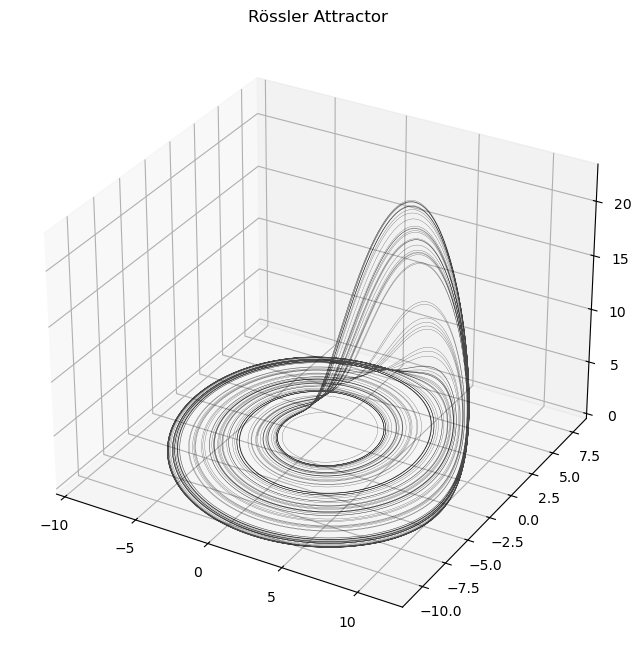

In [ ]:
# Plot the Rössler attractor
plot_attractor(ross_sol, title="Rössler Attractor", interactive=False)

### Lorenz system

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/lorenz.gif?raw=1" style="width: 70%; display: block; margin: auto;">

- Система Лоренца была одним из первых примеров, продемонстрировавших явление детерминированного хаоса. 
- Как и другие хаотические системы, эта демонстрирует чувствительную зависимость от начальных условий. 
- Кроме того, он генерирует явно случайные и непредсказуемые закономерности, несмотря на то, что подчиняется детерминированным законам.

- Изучение системы Лоренца имело глубокие последствия во многих областях: от метеорологии и климатологии до инженерии и экономики. 
- Он бросил вызов предыдущим представлениям о предсказуемости физических систем и способствовал развитию теории хаоса посредством:
    - углубление понимания сложных систем, 
    - подчеркивая ограничения существующих моделей прогнозирования в системах с хаотической динамикой, 
    - стимулирование новых подходов к анализу и контролю таких систем.

Система Лоренца определяется следующим набором нелинейных ОДУ:

\begin{align*}
\frac{dx}{dt} &= \sigma(y - x), \\
\frac{dy}{dt} &= x(\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z,
\end{align*}

Типичными значениями, при которых система Лоренца ведет себя хаотично, являются $\sigma = 10$, $\rho = 28$ и $\beta = \frac{8}{3}$.

### Показатели Ляпунова в непрерывных системах более высокой размерности 

- Ранее мы ввели  [показатель Ляпунова](#ляпунова-показатель) $\lambda$ как инструмент обнаружения хаоса. 
- Для логистической карты мы показали, что при $\lambda > 0$ динамика системы хаотична.

- В непрерывных системах более высокой размерности анализ показателей Ляпунова остается важнейшим методом понимания динамики системы. 
- В частности, их еще можно использовать для определения стабильности и наступления хаоса. 
- Однако в этой ситуации все становится сложнее.

- В одномерных дискретных системах, таких как Логистическая карта, обычно имеется один показатель Ляпунова. 
- Вместо этого в непрерывной системе размерности $n$ обычно имеется $n$ показателей Ляпунова. 
- Вычисление этих показателей включает в себя сложные численные методы для обработки развивающейся динамики касательного пространства. 
- Их расчет также требует больших вычислительных затрат и зависит от числовой точности. 
- Кроме того, на спектр Ляпунова большее влияние оказывают начальные условия и значения параметров.

- *Положительные показатели* указывают направления, в которых система демонстрирует чувствительную зависимость от начальных условий, что является характеристикой хаотической динамики. 
- *Нулевые показатели* предполагают нейтральную стабильность в определенных направлениях, часто связанную с сохраняющимися величинами или симметрией в системе. 
- *Отрицательные показатели* отражают направления конвергенции, указывая на стабильность в этих измерениях.

- Наибольший показатель Ляпунова по-прежнему остается наиболее важным для прогнозирования общего поведения системы, особенно хаоса. 
- Однако весь спектр может дать представление о более сложных динамиках, таких как:
    - смешанные режимы (одновременное стабильное и хаотичное поведение), 
    - гиперхаотические системы (системы с более чем одним положительным показателем Ляпунова).

- Для вычисления спектра Ляпунова мы используем функцию `computeLE(func, func_jac, x0, t, p)`, которая является частью сопутствующего кода к этой лекции. 
- Аргументы функции:
    - `func`, задающая дифференциальные уравнения динамической системы, 
    - `func_jac`, который является якобианом системы, т. е. частными производными, 
    - `x0`, который представляет начальные условия, 
    - `t`, вектор времени, определяющий временные шаги, по которым вычисляется траектория системы, 
    - `p`, параметры системы.

- Для системы Лоренца функция определяется следующим образом:

In [ ]:
def lorenz(t, x, sigma, rho, beta):
    res = np.zeros_like(x)
    res[0] = sigma*(x[1] - x[0])
    res[1] = x[0]*(rho - x[2]) - x[1]
    res[2] = x[0]*x[1] - beta*x[2]
    return res

— Якобиан системы — это матрица частных производных. 
- Рассмотрим общую динамическую систему с тремя переменными $x$, $y$ и $z$, представленную уравнениями:

$$
\begin{cases}
\dot{x} = f(x, y, z) \\
\dot{y} = g(x, y, z) \\
\dot{z} = h(x, y, z)
\end{cases}
$$

- Якобиан – это:

$$
J = \begin{bmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y} & \frac{\partial f}{\partial z} \\
\frac{\partial g}{\partial x} & \frac{\partial g}{\partial y} & \frac{\partial g}{\partial z} \\
\frac{\partial h}{\partial x} & \frac{\partial h}{\partial y} & \frac{\partial h}{\partial z}
\end{bmatrix}
$$

- Итак, для системы Лоренца имеем:

$$
J_{\text{Lorenz}} = \begin{bmatrix}
-\sigma & \sigma & 0 \\
\rho - z & -1 & -x \\
y & x & -\beta
\end{bmatrix}
$$

In [ ]:
def lorenz_jac(t, x,  sigma, rho, beta):
    res = np.zeros((x.shape[0], x.shape[0]))
    res[0,0], res[0,1] = -sigma, sigma
    res[1,0], res[1,1], res[1,2] = rho - x[2], -1., -x[0]
    res[2,0], res[2,1], res[2,2] = x[1], x[0], -beta
    return res

- Наконец, мы указываем начальные условия `x0`, вектор времени `t` и параметры системы `p`. 
- Последние в случае систем Лоренца — это $\sigma$, $\rho$ и $\beta$.

In [ ]:
x0 = np.array([1.5, -1.5, 20.])
t = np.arange(0, 1000, 1e-2)
sigma, rho, beta = 10., 28., 8/3
p = (sigma, rho, beta)

LEs, hist = computeLE(lorenz, lorenz_jac, x0, t, p=p)
print(f"Lyapunov Exponents: {LEs}")

Lyapunov Exponents: [ 9.06320944e-01 -2.38039941e-03 -1.45705049e+01]


- Один из показателей Ляпунова положителен. 
- Это говорит о том, что система Лоренца, настроенная с определенными значениями $\sigma$, $\rho$ и $\beta$, демонстрирует хаотическое поведение в одном направлении.

### Бифуркационные диаграммы в непрерывных системах более высокой размерности 

- При изучении Логистической карты мы ввели [бифуркационную диаграмму](#бифуркационные-диаграммы), которая представляет собой последовательность удвоений периода, возникающих при изменении управляющего параметра. 
- Мы можем вычислить бифуркационные диаграммы и для непрерывных систем более высокой размерности. 
- По сравнению с одномерными дискретными системами есть два важных отличия.

1. Поскольку у нас больше параметров системы, нам следует менять по одному.

2. Поскольку система непрерывна, переменные системы принимают значения в непрерывном интервале. 
     - В континууме мы не можем построить все значения, принимаемые временным рядом. 
     - Чтобы обнаружить удвоение периода, мы можем построить локальные максимумы и минимумы временного ряда. 
     - В режиме сжатия временной ряд будет колебаться между ограниченным числом локальных минимумов/максимумов. 
     - При наступлении хаоса количество локальных минимумов/максимумов начнет расти.

- Что касается показателя Ляпунова, мы будем использовать функцию из сопутствующего кода этого курса `plot_bifurcation_diagram`. 
- Функция принимает следующие аргументы: 
- `func`, `func_jac`, `x0`, `time_vector` такие же, как и раньше. 
— «Параметры» — это набор параметров, которые мы хотим попробовать. Меняться должен только один параметр, остальные остаются постоянными. 
- `p_idx` — это индекс параметра, который меняется в `parameters`. 
- `max_time` — это количество временных шагов из `time_vector`, используемое для оценки показателей Ляпунова. Если оставить значение «Нет», будут использоваться все временные шаги. Поскольку эта функция занимает много времени, рекомендуется установить ограничение.

- Далее мы вычисляем бифуркационную диаграмму системы Лоренца при изменении параметра $\rho \in [1,100]$. 
- Остальные параметры остаются фиксированными: $\sigma=10$ и $\beta = 8/3$.

In [ ]:
# Specify the parameters to try
sigma, beta = 10, 8/3
r_values = np.arange(20, 100, 0.05)
params = np.array([np.tile(sigma, len(r_values)), r_values, np.tile(beta, len(r_values))]).T

x0 = [1.5, -1.5, 20.]  # Initial conditions
t = np.arange(0, 10, 0.002) # Time vector

  0%|          | 0/1600 [00:00<?, ?it/s]

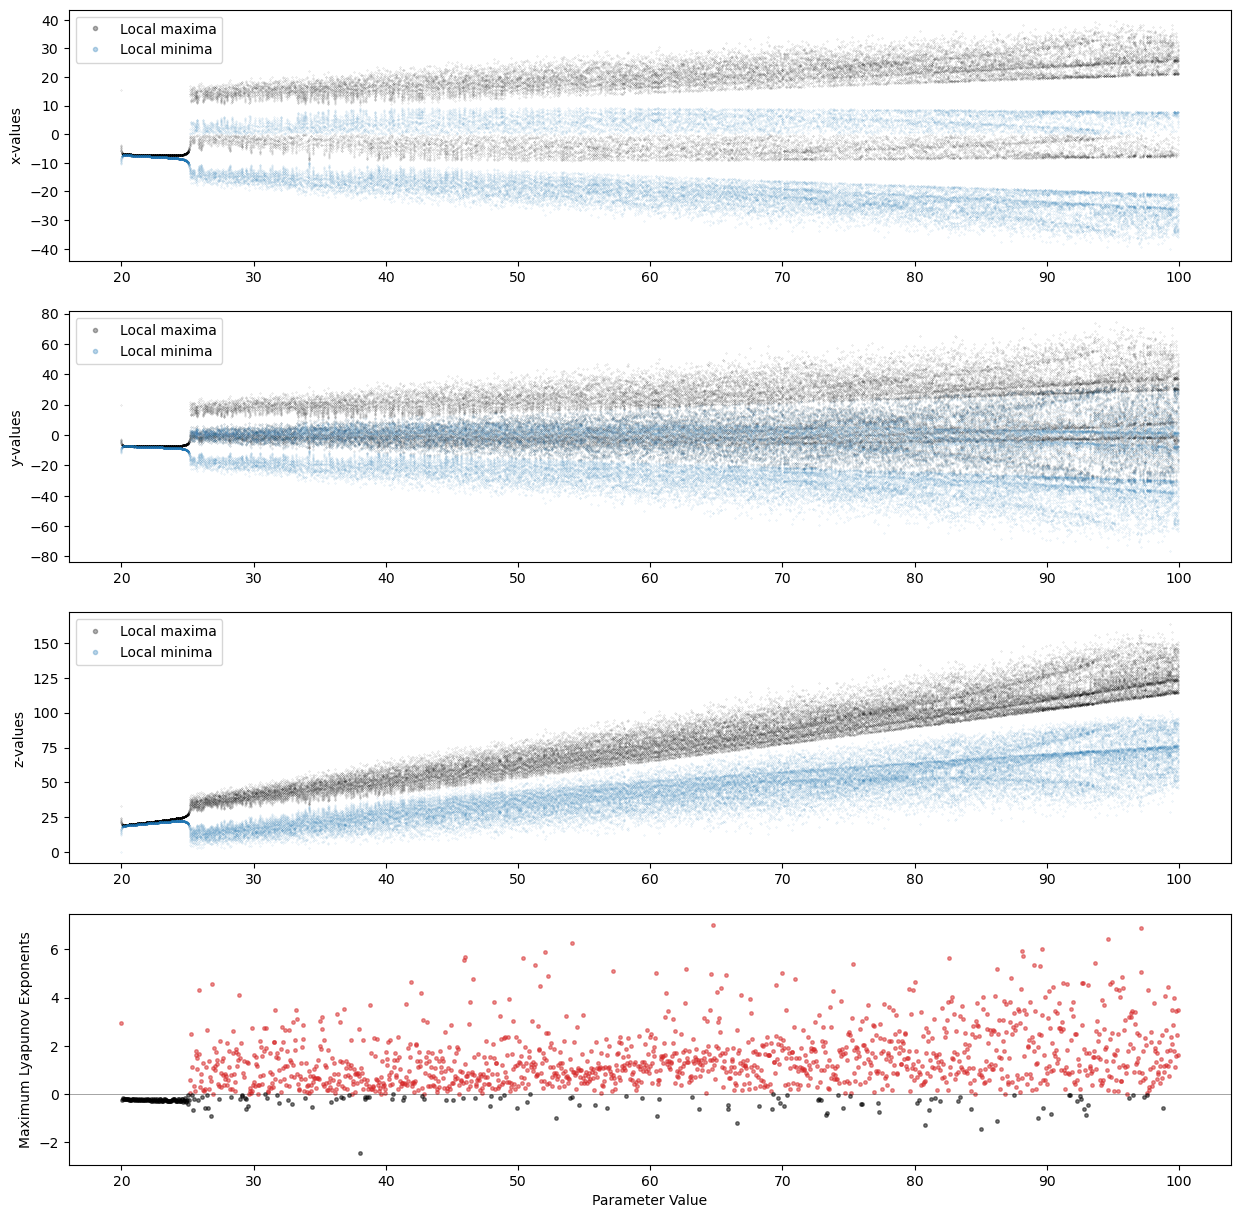

In [ ]:
plot_bifurcation_diagram(func=lorenz, func_jac=lorenz_jac,
                         x0=x0, time_vector=t,
                         parameters=params, p_idx=1, max_time=500)

- Функция сгенерировала 4 графика. 
- Первые три — это бифуркационные диаграммы переменных системы $x$, $y$ и $z$. 
- Последний график показывает наибольшее значение среди трех показателей Ляпунова. 
- Мы видим связь между показателями Ляпунова и наступлением хаоса в системе. 
- Когда наибольший показатель Ляпунова положителен, система демонстрирует хаотическое поведение хотя бы в одном направлении.

**💡 подсказка** 
- Если запуск `plot_bifurcation_diagram` занимает слишком много времени, попробуйте уменьшить количество исследуемых конфигураций. 
— Например, попробуйте `r_values ​​= np.arange(20, 100, 0,5)`.

## Phase space

- Текущее состояние системы рассматривается как точка в *фазовом пространстве* или *пространстве состояний*. 
- Фазовое пространство представляет все возможные состояния системы. 
- Он определяет, как системные переменные $x, y, z, \dots$ взаимодействуют и развиваются.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/phase_space.png?raw=1" style="width: 100%; display: block; margin: auto;">

- Фазовое пространство дает нам полное знание о текущем состоянии системы. 
- Нас особенно интересует ее *траектория* (или орбита) во времени. 
- Зная это, мы можем делать прогнозы о будущих состояниях системы. 
- Очевидно, что это имеет ключевое значение для прогнозирования временных рядов.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/predict.png?raw=1" style="width: 40%; display: block; margin: auto;">

- To identify the trajectory of the system in the phase space, we have to identify properties of its attractor.
- One of these, is its *dimensionality*.
- To determine the dimensionality of an attractor, especially strange attractors of chaotics systems, we have to revise our concept of dimensionality.

---

## Fractal dimensions

- Обычно мы понимаем размеры с геометрической точки зрения: длина, ширина, глубина. 
- Обычные геометрические объекты, такие как линия, квадрат или куб, требуют для своего содержания все большего числа измерений. 
- Понятие размеров также связано с общими мерами этих объектов, такими как их периметр, площадь и объем, которые требуют все большего числа измерений для их выражения.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/dimensions.png?raw=1" style="width: 50%; display: block; margin: auto;">


- С этой точки зрения измерения являются целыми числами, и идея дробного измерения, например, $d=1,26$, не имеет особого смысла..

- Давайте теперь пойдем другим путем. 
- Давайте подумаем о размерах как о том, насколько они увеличивают некоторую величину. 
- Например, давайте удвоим край квадрата. 
— Периметр увеличится в 2 раза, а площадь — в 4 раза. 
- Если удвоить ребро куба, его объем увеличится в 8 раз.

- Аналогично мы можем разделить ребро на $r$ частей и посчитать, сколько частей мы получим. 
- Пусть $r$ — *коэффициент масштабирования*, а $N$ — количество получаемых частей. 
- Ибо строка прямая:

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/line.png?raw=1" style="width: 40%; display: block; margin: auto;">


| $r$ | $N$ |
|:-----:|:-----:|
| 1 | 1 |
| 2 | 2 |
| 4 | 4 |

- Мы легко можем вывести следующее правило: $N=r^D$ при $D=1$.

- Перейдем на квадрат и повторим те же вычисления.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/square.png?raw=1" style="width: 40%; display: block; margin: auto;">

| $r$ | $N$ |
|:-----:|:-----:|
| 1 | 1 |
| 2 | 4 |
| 4 | 16 |

- Применяется то же правило, что и раньше: $N=r^D$, но теперь $D=2$.

- Наконец, для куба имеем:

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/cube.png?raw=1" style="width: 40%; display: block; margin: auto;">

| $r$ | $N$ |
|:-----:|:-----:|
| 1 | 1 |
| 2 | 8 |
| 4 | 64 |

- Количество частей по-прежнему равно $N=r^D$, когда $D=3$. 
— Пока что значение $D$ соответствует тому, как мы привыкли воспринимать размерность этих объектов.

- Далее переходим к фрактальному объекту, называемому кривой Коха (или снежинкой Коха). 
- Пытаемся аппроксимировать длину кривой отрезками уменьшающейся длины. 
- Начнем с отрезка длиной $r=1$.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/koch1.png?raw=1" style="width: 55%; display: block; margin: auto;">

- Если разделить отрезок на $r=3$, то можно уместить $N=4$ кусков.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/koch2.png?raw=1" style="width: 55%; display: block; margin: auto;">

- Если мы разделим его на $r=9$, мы сможем уместить $N=16$ частей и так далее.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/koch3.png?raw=1" style="width: 55%; display: block; margin: auto;">

- Соотношение $N=r^D$, которое мы отвергли ранее, является ключом к определению размерности этого фрактального объекта. 
- В частности, у нас есть

$$4 = 3^D \rightarrow \log(4) = \log(3)\cdot D \rightarrow = D = \frac{\log(4)}{\log(3)} \approx 1.26 $$

- Интуитивно подумайте, что нам нужно больше «размерности», чтобы содержать этот объект, чем то, что нам нужно, чтобы содержать линию, но меньше, чем то, что нам нужно, чтобы содержать область.

— Другой пример — треугольник Серпинского.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/triangle.png?raw=1" style="width: 70%; display: block; margin: auto;">

- Следуя той же процедуре, мы имеем $D = \frac{\log(3)}{\log(2)} \approx 1,58$. 
- Понятно, что нам нужно больше «размерности», чтобы вместить этот объект, чем кривая Коха, но из-за всех «дырок» все же меньше площади.

### Chaos and Fractals

- Между хаосом и фракталами существует глубокая и повсеместная связь. 
- Например, некоторые бифуркационные диаграммы самоподобны. 
- Если мы увеличим значение $r \approx 3,83$ бифуркационной диаграммы Логистической карты, ситуация рядом будет выглядеть как уменьшенная и слегка искаженная версия всей диаграммы. 
- То же самое справедливо и для всех остальных нехаотичных точек.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/logistic-zoom.gif?raw=1" style="width: 60%; display: block; margin: auto;">

<div style="text-align: center; font-size: 15px;">Image: <a href="https://github.com/jonnyhyman/Chaos">jonnyhyman</a></div>

- Еще одна прекрасная связь между множеством Мандельброта и картой бифуркации логистической карты.


<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/Logistic_Map_Bifurcations_Underneath_Mandelbrot_Set.gif?raw=1" style="width: 55%; display: block; margin: auto;">

<div style="text-align: center; font-size: 15px;">Image: <a href="https://github.com/jonnyhyman/Chaos">jonnyhyman</a></div>

- Траектория странного аттрактора не заполняет фазовое пространство, а лишь его часть. 
- Другими словами, размерность аттрактора хаотической системы фрактальна. 
- Определение такой размерности является ключом к *реконструкции* фазового пространства.

---

## Phase space reconstruction

- Как и в предыдущих примерах, динамические системы часто управляются эволюцией нескольких взаимодействующих переменных $x_1, x_2, \dots, x_D$. 
- Однако в большинстве реалистичных сценариев мы не можем напрямую наблюдать за всеми переменными системы. 
- Мы можем измерять только *частичные наблюдения*, т.е. подмножество переменных системы или их функцию $y = f(x_1, x_2, \dots, x_D)$.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/partial.png?raw=1" style="width: 40%; display: block; margin: auto;">

**Примеры** 
- В системе Лоренца мы можем наблюдать только переменную $y(t)$. 
- При прогнозировании погоды метеорологи часто имеют доступ только к частичным наблюдениям за подмножеством переменных, таких как температура, давление, влажность, характер ветра и географические особенности. Однако существует множество других переменных, которые недоступны, например, детальные атмосферные условия, микроклимат, температура океанов, течения, наличие загрязняющих веществ, изменения солнечной радиации и т. д.

- Можем ли мы восстановить траекторию движения системы в пространстве состояний по частичным наблюдениям? 
- Если мы сможем это сделать, мы сможем предсказывать будущие состояния систем, включая наблюдаемые временные ряды.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/reconstruct.png?raw=1" style="width: 60%; display: block; margin: auto;">

### Теорема вложения Такенса 

- Предположим, что это динамическая система с неизвестным или частично известным пространством состояний. 
- Теорема вложения Такенса гласит, что можно восстановить динамику всей системы, используя серию наблюдений по *одной* переменной. 
- Это означает, что даже если мы не можем наблюдать все состояние системы напрямую, мы все равно можем понять ее динамику посредством правильного анализа одной наблюдаемой переменной.

**Вектор внедрения временной задержки** 
- Пусть $x(t)$ — наблюдаемый временной ряд. 
- Вектор внедрения $\mathbf{e}(t) = [e_1, e_2, \dots, e_N]$ определяется как:

$$\begin{align} e_1(t) &= x(t) \\ e_2(t) &= x(t + \tau) \\ e_3(t) &= x(t + 2\tau) \\ \dots \\ e_m(t) &= x(t + (m-1)\tau) \end{align}$$

-Здесь $\tau$ — выбранная *задержка*, а $m$ — *размерность встраивания*.

In [ ]:
def takens_embedding(data, delay, dimension):
    embedding = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embedding = np.append(embedding, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embedding.transpose()

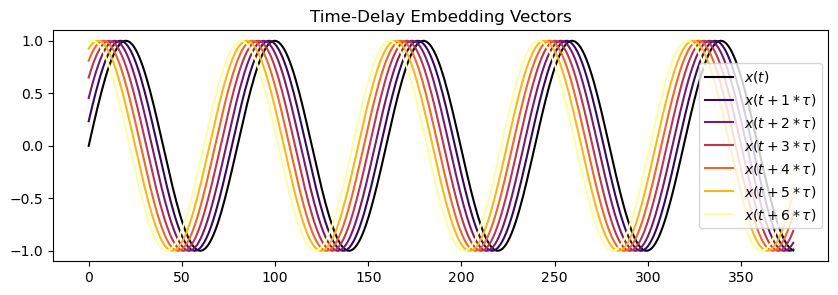

In [ ]:
t = np.linspace(0, 10*np.pi, 400)
x = np.sin(t)                      # time series
tau = 3                            # time delay
N = 7                              # embedding dimension
emb = takens_embedding(x, tau, N)  # compute embeddings

cmap = plt.get_cmap('inferno')
fig, ax = plt.subplots(1,1, figsize=(10,3))
for i in range(N):
    _label = f"$x(t + {i}*\\tau )$" if i > 0 else f'$x(t)$'
    ax.plot(emb[:,i], label=_label, color=cmap(i / (N - 1)))
plt.legend()
plt.title('Time-delay embedding vectors')
plt.show()

**Формулировка теоремы**

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/takens.png?raw=1" style="width: 60%; display: block; margin: auto;">

- Теорема Такенса не уточняет, как выбирать $m$ и $\tau$. 
- Он лишь утверждает, что для системы с аттрактором (дробной) размерности $D$ размерность вложения $m > 2D$ достаточна для обеспечения диффеоморфного (топологически эквивалентного) вложения в условиях общего положения. 
- Интуитивно понятно, что размерность внедрения должна быть достаточно большой, чтобы полностью развернуть аттрактор в реконструированном фазовом пространстве, уловив его динамику без самопересечений. 
- Как мы оцениваем $m$ и $\tau$ по одному временному ряду?

#### Оценка задержки $\tau$ 

- Мы можем полагаться на *взаимную информацию* (MI) для вычисления $\tau$. 
- МИ количественно определяет количество информации между двумя случайными величинами. 
- Нас интересует вычисление MI между временным рядом и его лагированной версией. 
- Думайте о MI как о более мощной автокорреляции, которая фиксирует также нелинейные отношения. 
- Когда MI достигает своего минимума за определенный лаг $\tau$, это означает, что наблюдения достаточно независимы, сохраняя при этом значимую информацию о динамике системы.

1. Вычислите минимум $x_\text{min}$ и максимум $x_\text{max}$ временного ряда. 
2. Разбить интервал $[x_\text{min}, x_\text{max}]$ на ячейки $n_\text{bins}$. 
3. Обозначим $p_t(h)$ вероятность того, что элемент $x(t)$ находится в $h$-м интервале. 
4. Обозначим $p_{t+\tau}(k)$ вероятность того, что элемент $x(t+\tau)$ находится в $k$-м интервале. 
5. Обозначим $p_{t, t+\tau}(h, k)$ вероятность того, что $x(t)$ находится в $h$-м интервале, а $x(t+\tau)$ — в $k$-м интервале.

6. Определите MI как

$$I(\tau) = - \sum \limits_{h=1}^{n_\text{bins}} \sum \limits_{k=1}^{n_\text{bins}} p_{t, t+\tau}(h, k) \log \frac{p_{t, t+\tau}(h, k)}{p_t(h) \cdot p_{t+\tau}(k)}$$

7. Вычисление$\tau^* = \text{argmin}_\tau I(\tau)$.

- Давайте напишем код Python для вычисления MI для временного ряда и его запаздывающих версий. 
- В качестве примера рассмотрим временной ряд $x(t)$ из системы Рёсслера.

In [ ]:
# Parameters
a, b, c = 0.2, 0.2, 5.7
y0 = [0.0, 2.0, 0.0]  # Initial conditions
T = 1500 # Final time
t_span = [0, T]  # Time span for the integration

# Solve the differential equations
solution = solve_ivp(rossler_system, t_span, y0, args=(a, b, c), dense_output=True)
t = np.linspace(0, T, int(5e3))
ross_sol = solution.sol(t)

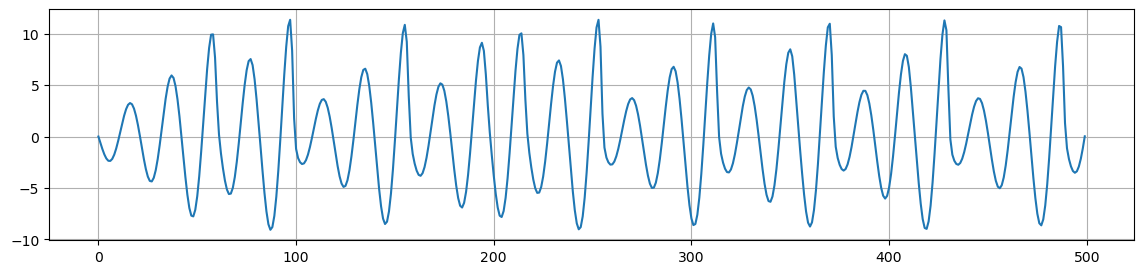

In [ ]:
ross_ts = ross_sol[0]
plt.figure(figsize=(14,3))
plt.plot(ross_ts[:500])
plt.grid()
plt.show()

In [ ]:
def mutual_information(data, delay, n_bins):
    """
    Calculate the mutual information for a given delay using histograms.
    """
    # Prepare delayed data
    delayed_data = data[delay:]
    original_data = data[:-delay]

    # Compute histograms
    p_x, bin_edges = np.histogram(original_data, bins=n_bins, density=True)
    p_y, _ = np.histogram(delayed_data, bins=bin_edges, density=True)
    p_xy, _, _ = np.histogram2d(original_data, delayed_data, bins=bin_edges, density=True)

    # Calculate mutual information
    mutual_info = 0
    for i in range(n_bins):
        for j in range(n_bins):
            if p_xy[i, j] > 0 and p_x[i] > 0 and p_y[j] > 0:
                mutual_info += p_xy[i, j] * np.log(p_xy[i, j] / (p_x[i] * p_y[j]))

    return mutual_info

- Теперь мы вычисляем МИ для разных значений $\tau$, отображаем его и находим его первый минимум. 
- Это дает нам оптимальную задержку внедрения. 
- Мы используем 50 ячеек, и, поскольку у нас 5000 точек данных, в каждой ячейке будет по 100 точек.

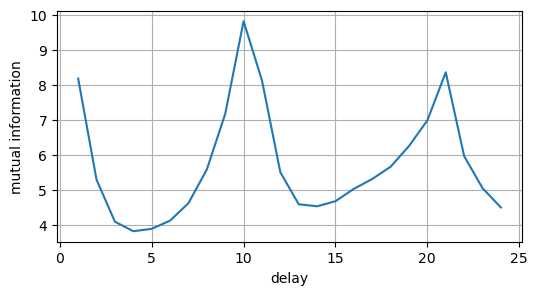

In [ ]:
MI = []
for i in range(1,25):
    MI = np.append(MI,[mutual_information(ross_ts,i,50)])
plt.figure(figsize=(6,3))
plt.plot(range(1,25), MI)
plt.xlabel('delay')
plt.ylabel('mutual information')
plt.grid()
plt.show()

- Мы видим, что оптимальное значение $\tau$ составляет $4$ или $5$. 

**Примечание** 
- Ситуация сильно меняется, если данные собираются с разной частотой. 
-  В этом примере мы использовали `t = np.linspace(0, 1500, int(5e3))`. 
- Попробуйте посмотреть, как все изменится для `t = np.linspace(0, 500, int(5e4))` вектора времени, который мы использовали ранее для рисования аттрактора в [системе Рёсслера](#rossler-system). 
-  На результат также влияет значение n_bins. 
     - Выбор такого рода гиперпараметров часто является деликатным выбором при оценке информационных теоретических величин, таких как MI.

#### Оценка размерности вложения $m$ 

- Мы можем оценить $m$, используя меру, называемую *ложными ближайшими соседями* (FNN). 
- *Ложные соседи* — это точки, которые кажутся близкими в низших измерениях из-за проекции, но на самом деле не являются близкими в пространстве более высоких измерений. 
— Основная идея FNN — увеличивать размерность встраивания до тех пор, пока доля ложных соседей не упадет ниже определенного порога.

1. Начните с низкой размерности вложения $m=1$ и вычислите реконструкцию фазового пространства с задержкой по времени. 

2. Для каждой точки восстановленного фазового пространства определить ближайшего соседа. 

3. Вычислить расстояние между каждой точкой и ее ближайшим соседом в текущем измерении вложения $m$, а затем в следующем более высоком измерении $m+1$.

4. Определите, является ли сосед «ложным», проверив, значительно ли увеличивается расстояние между точкой и ее ближайшим соседом при переходе от измерения $m$ к $m+1$. Сосед считается ложным, если: 

$$\frac{|R_{m+1} - R_m|}{R_m} > R_{tol}$$

- где 
- $R_m$ — расстояние между точкой и ее ближайшим соседом в размерности $m$, 
- $R_{m+1}$ — расстояние в размерности $m+1$, 
- $R_{tol}$ — это порог для принятия решения о том, является ли увеличение расстояния значительным.

5. Вычислите долю ложных ближайших соседей для текущего измерения. 

6. Повторяйте процесс, увеличивая $m$ до тех пор, пока доля ложных ближайших соседей не станет достаточно низким значением, указывающим на то, что аттрактор полностью развернут.

In [ ]:
def calculate_fnn(data, delay, max_emb_dim, R_tol=10):
    fnn_proportions = []
    for m in range(1, max_emb_dim + 1):

        # Compute embeddings in m and m+1
        emb_m = takens_embedding(data, delay, m)
        emb_m_plus_one = takens_embedding(data, delay, m + 1)

        # Compute the nearest neighbors in m
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_m[:-delay])
        distances, indices = nbrs.kneighbors(emb_m[:-delay])

        n_false_nn = 0
        for i in range(0, len(distances)):

            # Nearest neighbor of i in m and distance from it
            neighbor_index, R_m = indices[i, 1], distances[i, 1]

            # Dinstance in m+1 from the nearest neighbor in m
            R_m_plus_one = np.linalg.norm(emb_m_plus_one[i] - emb_m_plus_one[neighbor_index])

            # fNN formula
            if abs(R_m_plus_one - R_m) / R_m > R_tol:
                n_false_nn += 1

        fnn_proportion = n_false_nn / len(indices)
        fnn_proportions.append(fnn_proportion)

    return fnn_proportions

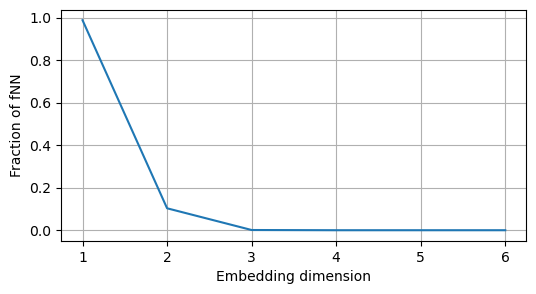

In [ ]:
nFNN = calculate_fnn(ross_ts, delay=5, max_emb_dim=6)

plt.figure(figsize=(6,3))
plt.plot(range(1,len(nFNN)+1),nFNN);
plt.xlabel('Embedding dimension')
plt.ylabel('Fraction of fNN')
plt.grid()
plt.show()

- Как мы видим, доля fNN падает до нуля при $m=3$. 
- Это имеет смысл, поскольку мы знаем, что система Рёсслера имеет три переменные состояния и ее аттрактор содержится более чем в двух измерениях. 
- Наконец-то мы готовы реконструировать аттрактор.

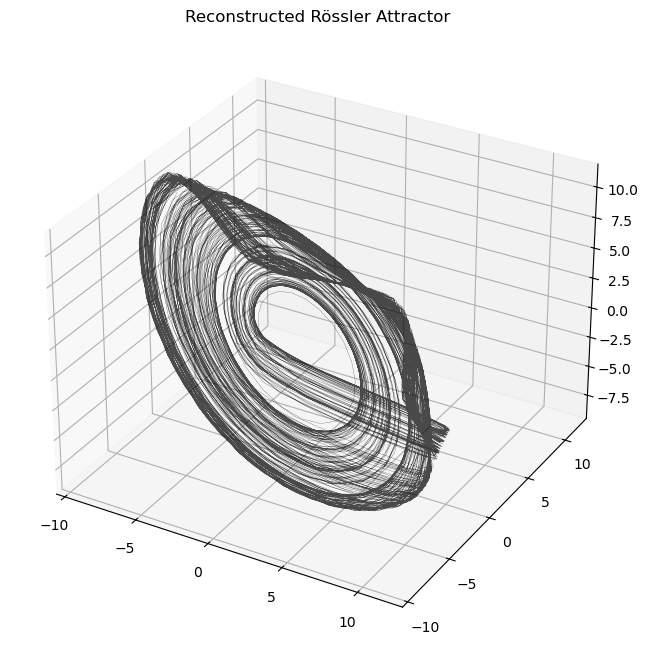

In [ ]:
emb = takens_embedding(ross_ts, delay=5, dimension=3)
plot_attractor(emb.T, title="Reconstructed Rössler Attractor", interactive=False)

- Реконструкция очень похожа на оригинальный аттрактор. 
- Помните, что реконструированный аттрактор не обязательно должен быть равен реальному аттрактору, а только диффеоморфен (топологически эквивалентен) ему. 

---

## Forecasting nonlinear time series

### Регрессия на вложениях Taken

- Вложения Такена связаны с оконным подходом к прогнозированию, который мы видели в предыдущей лекции. 
- Ниже мы покажем эту взаимосвязь на практическом примере прогнозирования. 
- Учитывая временной ряд $\{x(t)\}_{t = 1, 2, \dots, T}$, временную задержку $\tau$ и размерность вложения $m$, матрицу $\mathbf{E}$ вложений Такенса можно представить как:
$$
\mathbf{E} = \begin{pmatrix}
x(t)           & x(t+\tau)      & x(t+2\tau)     & \dots  & x(t+(m-1)\tau) \\
x(t+1)         & x(t+\tau+1)    & x(t+2\tau+1)   & \dots  & x(t+(m-1)\tau+1) \\
x(t+2)         & x(t+\tau+2)    & x(t+2\tau+2)   & \dots  & x(t+(m-1)\tau+2) \\
\vdots         & \vdots         & \vdots         & \ddots & \vdots \\
x(T-(m-1)\tau) & x(T-(m-2)\tau) & x(T-(m-3)\tau) & \dots  & x(T) \\
\end{pmatrix}
$$

- Каждая строка должна содержать достаточно информации, чтобы описать динамику системы на определенном временном шаге. 
- Мы можем использовать эту информацию, чтобы делать прогнозы на будущее. 
- Например, мы можем использовать первую строку $[x(t), x(t+\tau), x(t+2\tau) \dots x(t+(m-1)\tau)]$, чтобы предсказать следующее значение $x(t+m\tau)$.

- Сначала мы вычисляем вложения, используя в качестве размерности $m+1$. 
- Затем мы будем использовать в качестве входных данных все столбцы $\mathbf{E}$, кроме последнего, `emb[:,:-1]`, который будет целью. 
- Это соответствует взятию окна размером $m$ выборок, сделанных каждые $\tau$ временных шагов, и прогнозированию $\tau$ шагов вперед. 
- В приведенном ниже примере мы будем использовать RandomForestRegressor в качестве модели регрессии.

In [ ]:
def forecast_on_phase_space(y, delay, dimension, test_prop):

    # Compute embeddings
    emb = takens_embedding(y, delay=delay, dimension=dimension)

    # Create input and target
    X = emb[:, :-1]
    y = emb[:, -1]

    # Divide into train and test
    test_size = int(len(y)*test_prop)
    X_train = X[:-test_size, :]
    y_train = y[:-test_size]
    X_test = X[-test_size:, :]
    y_test = y[-test_size:]

    # Fit the regressor on the training data
    rf = RandomForestRegressor().fit(X_train, y_train)

    # Predict the test data
    preds = rf.predict(X_test)

    print(f'MSE: {mean_squared_error(y_test, preds):.3f}')
    plt.figure(figsize=(14,3))
    plt.plot(y_test, label='True')
    plt.plot(preds, label='Prediction')
    plt.grid()
    plt.legend()
    plt.show()

MSE: 0.138


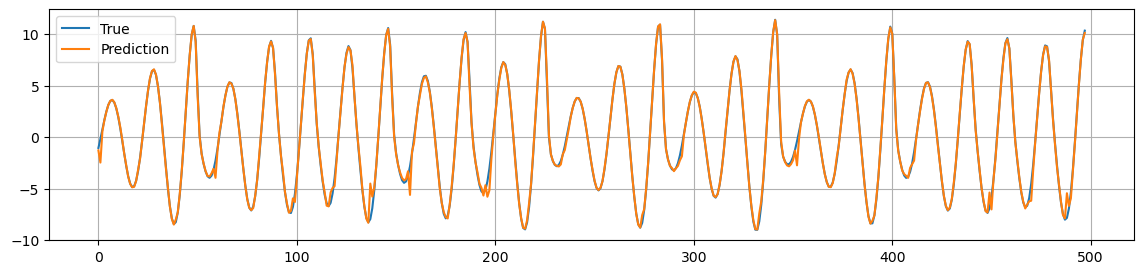

In [ ]:
forecast_on_phase_space(ross_ts, delay=5, dimension=3+1, test_prop=0.1)

- Как видим, мы получаем довольно хороший прогноз. 
- Это значит, что окно $[x(t), x(t+\tau), x(t+2\tau)\dots x(t+(m-1)\tau)]$ содержит достаточно информации для прогнозирования следующего значения $x(t+m\tau)$.

### Echo State Network

- Вместо использования временных вложений мы можем использовать состояния резервуара сети состояний эхо в качестве входных данных для нашей модели регрессии. 
- Мы выполним тот же прогноз на $\tau$-шаги вперед.

In [ ]:
Xtr, Ytr, Xte, Yte, scaler = make_forecasting_dataset(ross_ts[:,None],
                                                  horizon=5,
                                                  test_percent = 0.1)
print(f"Xtr shape: {Xtr.shape}\nYtr shape: {Ytr.shape}\nXte shape: {Xte.shape}\nYte shape: {Yte.shape}")

Xtr shape: (4495, 2)
Ytr shape: (4495, 1)
Xte shape: (495, 2)
Yte shape: (495, 1)


- Далее мы инициализируем Резервуар и вычисляем состояния.

In [ ]:
res= Reservoir(n_internal_units=900,
               spectral_radius=0.99,
               input_scaling=0.1,
               connectivity=0.25)

n_drop=10
states_tr = res.get_states(Xtr[None,:,:], n_drop=n_drop, bidir=False)
states_te = res.get_states(Xte[None,:,:], n_drop=n_drop, bidir=False)
print(f"states_tr shape: {states_tr.shape}\nstates_te shape: {states_te.shape}")

states_tr shape: (1, 4485, 900)
states_te shape: (1, 485, 900)


- Далее мы уменьшим размерность состояний Резервуара с помощью PCA. 
- Это ускорит подбор регрессионной модели. 
- Обычно мы выбираем достаточно большую сумму, например, 50 долларов. 
- Однако здесь мы уменьшим число размерностей до $m=3$. 
— Это позволит нам позже создать интересную визуализацию.

In [ ]:
pca = PCA(n_components=3)
states_tr_pca = pca.fit_transform(states_tr[0])
states_te_pca = pca.transform(states_te[0])
print(f"states_tr shape: {states_tr_pca.shape}\nstates_te shape: {states_te_pca.shape}")

states_tr shape: (4485, 3)
states_te shape: (485, 3)


- Далее мы подгоняем модель регрессии к состояниям резервуара и вычисляем прогнозы. 
- Обратите внимание, насколько хороши предсказания, даже если мы используем такие маленькие state.

In [ ]:
# Fit the regression model
rf = RandomForestRegressor().fit(states_tr_pca, Ytr[n_drop:,:].ravel())

# Compute the predictions
Yhat_pca = rf.predict(states_te_pca)[...,None]

# Compute the mean squared error
mse = mean_squared_error(scaler.inverse_transform(Yhat_pca), Yte[n_drop:,:])
print(f"MSE: {mse:.2f}")

MSE: 0.17


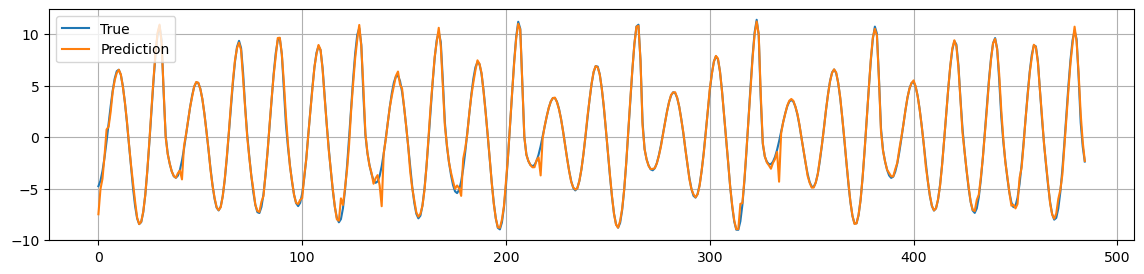

In [ ]:
plt.figure(figsize=(14,3))
plt.plot(Yte[n_drop:,:], label='True')
plt.plot(scaler.inverse_transform(Yhat_pca), label='Prediction')
plt.legend()
plt.grid()
plt.show()

- ESN особенно хорош в прогнозировании нелинейных временных рядов и хаотических систем в целом. 
- Причина в том, что Резервуару очень хорошо удается воспроизводить динамику базовой системы. 
- Чтобы убедиться в этом, мы можем построить график динамики состояний Резервуара и понаблюдать, насколько точно траектория соответствует реальному фазовому пространству.

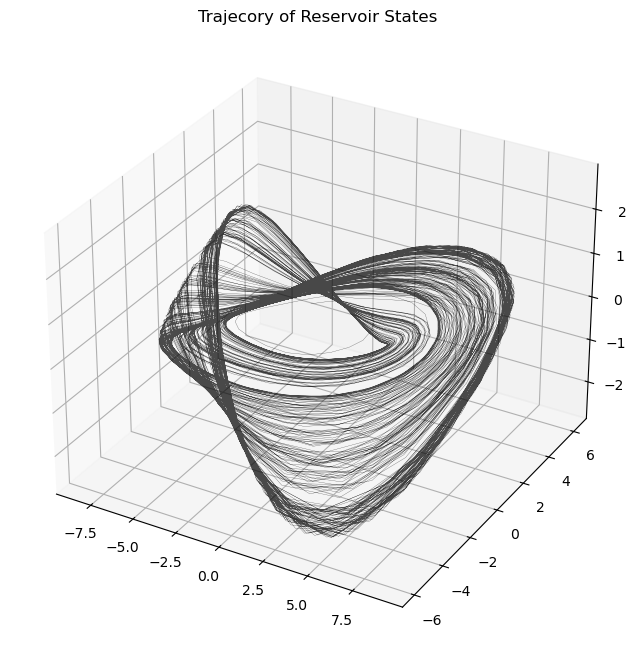

In [ ]:
plot_attractor(states_tr_pca.T, title="Trajecory of Reservoir States", interactive=False)

---
## Exercises

### Упражнение 1 

- Вычислить карту бифуркации системы Ресслера. 
- Оставьте фиксированными параметры $a = b = 0.2$. 
- Измените параметр $c$, как показано ниже. 
- Для каждого значения $c$ вычислите и постройте локальные максимумы временного ряда $z(t)$, используя функцию `scipy.signal.find_peaks`. У вас должен получиться график, похожий на рисунок ниже. 
- Определите первую точку бифуркации, прежде чем система станет хаотичной. 
- Объясните, почему для логистической карты не требовалось вычисление локальных максимумов (пиков).

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/rossler_attractor.png?raw=1" style="width: 100%; display: block; margin: auto;">

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks


plt.style.use('default')

# СИСТЕМА РЁССЛЕРА
def rossler(t, state, a, b, c):
    x, y, z = state
    dx = -y - z
    dy = x + a * y
    dz = b + z * (x - c)
    return [dx, dy, dz]

a = 0.2
b = 0.2

c_values = np.linspace(2, 6, 800)  

c_plot = []
x_peaks_plot = []

In [31]:
print("Вычисление карты бифуркации...")

for i, c in enumerate(c_values):
    if i % 100 == 0:
        print(f"Прогресс: {i}/{len(c_values)}")
 
    y0 = [1.0, 1.0, 1.0]

    t_span = (0, 500)  
    t_eval = np.linspace(0, 500, 10000)

    sol = solve_ivp(
        rossler, t_span, y0,
        args=(a, b, c),
        t_eval=t_eval,
        rtol=1e-8, atol=1e-10
    )

    x = sol.y[0]  
    t = sol.t

    cutoff = int(0.8 * len(t))
    x_steady = x[cutoff:]

    peaks, _ = find_peaks(x_steady, height=np.mean(x_steady))

    for peak_val in x_steady[peaks]:
        c_plot.append(c)
        x_peaks_plot.append(peak_val)


Вычисление карты бифуркации...
Прогресс: 0/800
Прогресс: 100/800
Прогресс: 200/800
Прогресс: 300/800
Прогресс: 400/800
Прогресс: 500/800
Прогресс: 600/800
Прогресс: 700/800


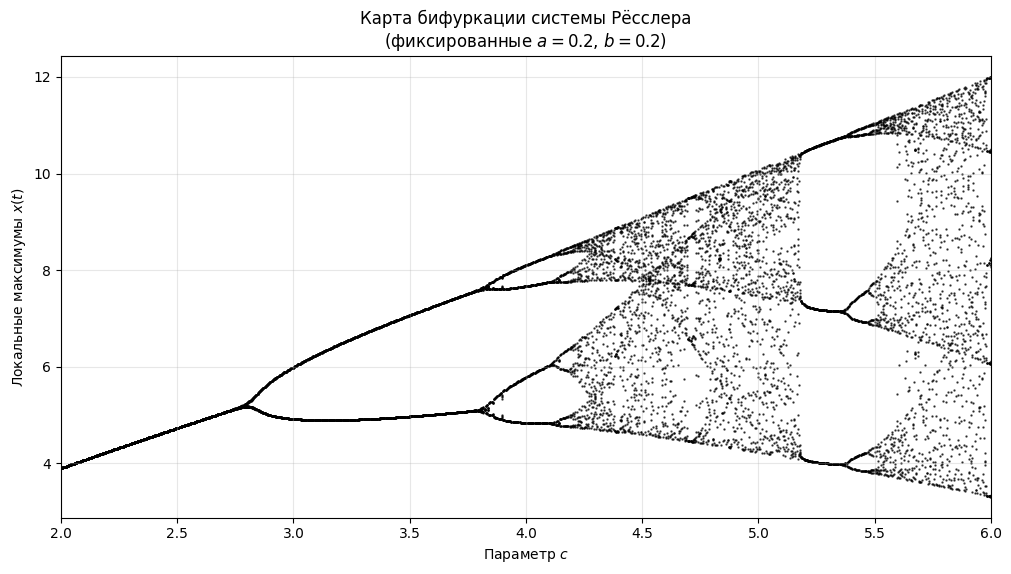


 Анализ:
- При c < ~2.8 система имеет один устойчивый предельный цикл → один пик.
- При c ≈ 2.8–3.0 происходит первая бифуркация (удвоение периода) → два пика.
- При дальнейшем увеличении c появляются 4, 8, ... пиков → переход к хаосу.
- Первая точка бифуркации: c ≈ 2.85

 Почему для логистической карты не нужны пики?
→ Логистическая карта — это дискретная динамическая система: x_{n+1} = r * x_n * (1 - x_n).
  Каждая итерация даёт одно значение x_n, которое уже является 'состоянием' системы.
  В бифуркационной диаграмме мы просто строим все x_n после переходного процесса.
→ В непрерывных системах (как Рёсслер) состояние — непрерывная функция x(t).
  Чтобы получить дискретные точки для диаграммы, нужно выделить характерные события —
  например, локальные максимумы (пики).


In [32]:


# ПОСТРОЕНИЕ КАРТЫ БИФУРКАЦИИ 
plt.figure(figsize=(12, 6))
plt.scatter(c_plot, x_peaks_plot, s=0.5, color='black', alpha=0.7)
plt.xlabel('Параметр $c$')
plt.ylabel('Локальные максимумы $x(t)$')
plt.title('Карта бифуркации системы Рёсслера\n(фиксированные $a=0.2$, $b=0.2$)')
plt.grid(True, alpha=0.3)
plt.xlim(2, 6)
plt.show()

# ОПРЕДЕЛЕНИЕ ПЕРВОЙ ТОЧКИ БИФУРКАЦИИ 

print("\n Анализ:")
print("- При c < ~2.8 система имеет один устойчивый предельный цикл → один пик.")
print("- При c ≈ 2.8–3.0 происходит первая бифуркация (удвоение периода) → два пика.")
print("- При дальнейшем увеличении c появляются 4, 8, ... пиков → переход к хаосу.")
print("- Первая точка бифуркации: c ≈ 2.85")

print("\n Почему для логистической карты не нужны пики?")
print("→ Логистическая карта — это дискретная динамическая система: x_{n+1} = r * x_n * (1 - x_n).")
print("  Каждая итерация даёт одно значение x_n, которое уже является 'состоянием' системы.")
print("  В бифуркационной диаграмме мы просто строим все x_n после переходного процесса.")
print("→ В непрерывных системах (как Рёсслер) состояние — непрерывная функция x(t).")
print("  Чтобы получить дискретные точки для диаграммы, нужно выделить характерные события —")
print("  например, локальные максимумы (пики).")

### Упражнение 2 

- Вычислите (фрактальную) размерность объекта, показанного на рисунке ниже.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l11/menger-sr.jpeg?raw=1" style="width: 40%; display: block; margin: auto;">

Уровень 2: 400 кубиков


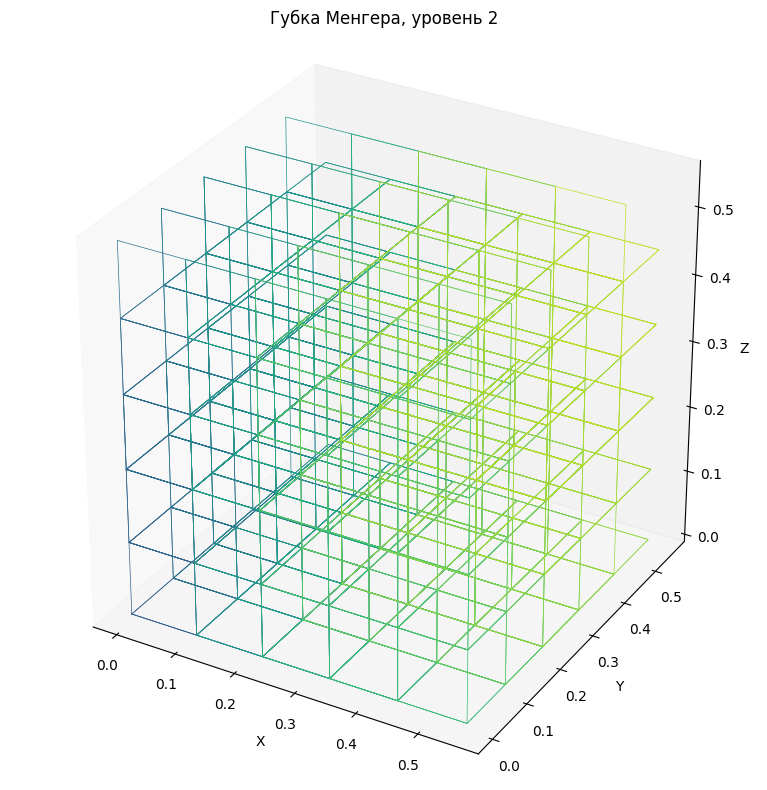

In [33]:
# губка менгера


from mpl_toolkits.mplot3d import Axes3D
from itertools import product

def menger_sponge(level, size=1.0):

    if level == 0:
        return [(0.0, 0.0, 0.0, size, size, size)]

    prev = menger_sponge(level - 1, size / 3.0)
    result = []
    for x, y, z, dx, dy, dz in prev:

        for i, j, k in product(range(3), repeat=3):

            if (i == 1 and j == 1 and k == 1) or \
               (i == 1 and j == 1 and k != 1) or \
               (i == 1 and j != 1 and k == 1) or \
               (i != 1 and j == 1 and k == 1):
                continue  

            new_x, new_y, new_z = x + i * dx, y + j * dy, z + k * dz
            result.append((new_x, new_y, new_z, dx, dy, dz))

    return result

level = 2  
cubes = menger_sponge(level)

print(f"Уровень {level}: {len(cubes)} кубиков")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(cubes)))

for i, (x, y, z, dx, dy, dz) in enumerate(cubes):
    xx = [x, x+dx, x+dx, x, x]
    yy = [y, y, y+dy, y+dy, y]
    zz = [z, z, z, z, z]
    ax.plot3D(xx, yy, zz, color=colors[i], linewidth=0.5)

    xx = [x, x+dx, x+dx, x, x]
    yy = [y, y, y, y, y]
    zz = [z, z, z+dz, z+dz, z]
    ax.plot3D(xx, yy, zz, color=colors[i], linewidth=0.5)

    xx = [x, x, x+dx, x+dx, x]
    yy = [y, y+dy, y+dy, y, y]
    zz = [z, z, z, z, z]
    ax.plot3D(xx, yy, zz, color=colors[i], linewidth=0.5)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Губка Менгера, уровень {level}')
ax.set_box_aspect([1,1,1])
ax.grid(False)
plt.tight_layout()
plt.show()

### Упражнение 3 

- Постройте аттрактор Лоренца для $\sigma = 10$, $\rho = 28$ и $\beta = \frac{8}{3}$.

Решение системы Лоренца...


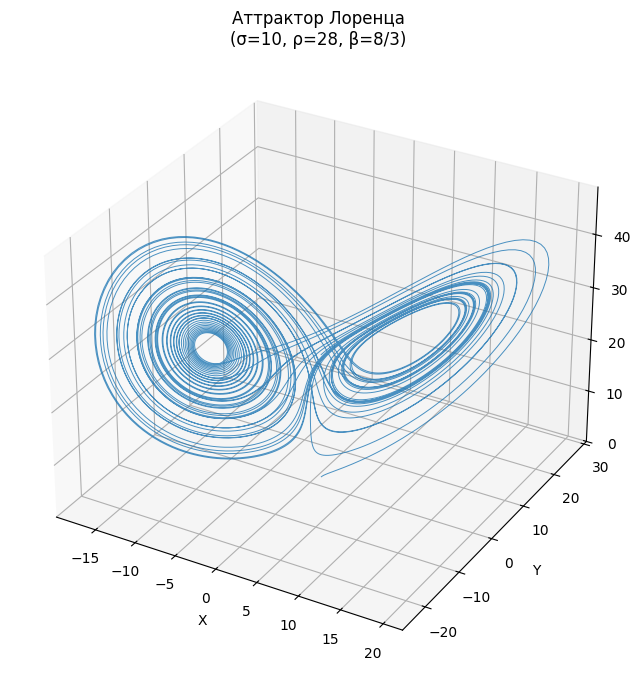

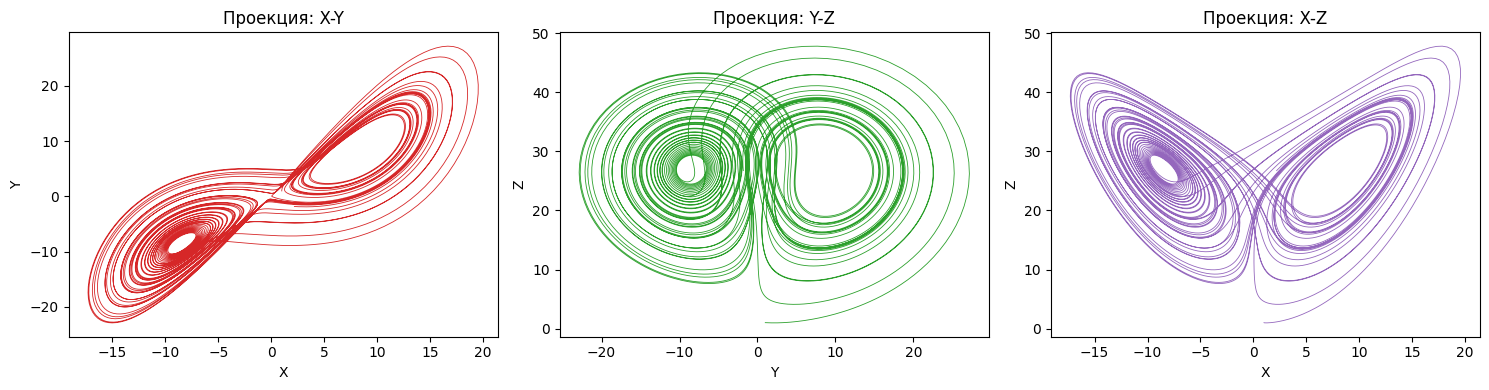

In [34]:
from scipy.integrate import solve_ivp

plt.style.use('default')


def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0


initial_state = [1.0, 1.0, 1.0]


t_span = (0, 50)         
t_eval = np.linspace(0, 50, 10000)  


print("Решение системы Лоренца...")
sol = solve_ivp(
    lorenz,
    t_span,
    initial_state,
    args=(sigma, rho, beta),
    t_eval=t_eval,
    rtol=1e-9,
    atol=1e-12
)

x, y, z = sol.y


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, color='tab:blue', linewidth=0.7, alpha=0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Аттрактор Лоренца\n(σ=10, ρ=28, β=8/3)')
plt.show()


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(x, y, color='tab:red', linewidth=0.6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Проекция: X-Y')

plt.subplot(1, 3, 2)
plt.plot(y, z, color='tab:green', linewidth=0.6)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Проекция: Y-Z')

plt.subplot(1, 3, 3)
plt.plot(x, z, color='tab:purple', linewidth=0.6)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Проекция: X-Z')

plt.tight_layout()
plt.show()

### Упражнение 4 

- Используйте вложение Taken, чтобы восстановить аттрактор Лоренца по временному ряду его первой переменной состояния $x(t)$. 
- Вычислите оптимальную временную задержку $\tau$ и оптимальную размерность вложения $m$, используя алгоритмы взаимной информации и ложных ближайших соседей.

Длина временного ряда: 10000
Форма X_embedded до согласования: (9980, 3)
Форма после согласования: X=(9979, 3), y=(9979,)

RMSE Ridge: 0.0291
RMSE Random Forest: 0.0440


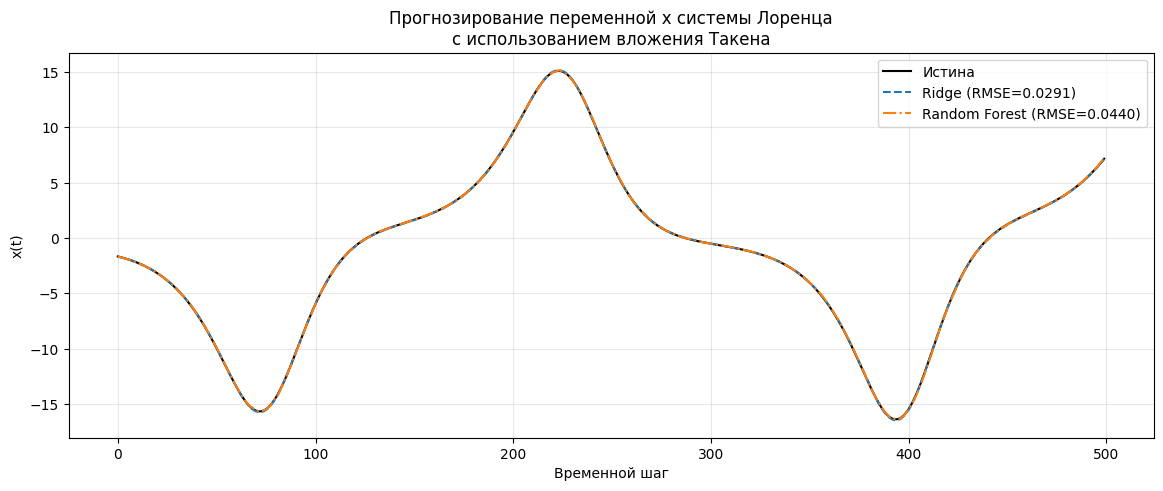

In [35]:
from scipy.integrate import solve_ivp
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

sigma, rho, beta = 10.0, 28.0, 8.0 / 3.0
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 50)
t_eval = np.linspace(0, 50, 10000)

sol = solve_ivp(lorenz, t_span, initial_state, args=(sigma, rho, beta), t_eval=t_eval)
x, y, z = sol.y
observed = x.copy()
print(f"Длина временного ряда: {len(observed)}")

def takens_embedding(data, delay, dimension):
    N = len(data) - (dimension - 1) * delay
    if N <= 0:
        raise ValueError("Слишком большие delay или dimension")
    embedded = np.zeros((N, dimension))
    for i in range(dimension):
        embedded[:, i] = data[i * delay : i * delay + N]
    return embedded

tau = 10      
d = 3         

X_embedded = takens_embedding(observed, tau, d)
print(f"Форма X_embedded до согласования: {X_embedded.shape}")


y_target = observed[(d - 1) * tau + 1 : (d - 1) * tau + 1 + len(X_embedded)]


min_len = min(len(X_embedded), len(y_target))
X_embedded = X_embedded[:min_len]
y_target = y_target[:min_len]

print(f"Форма после согласования: X={X_embedded.shape}, y={y_target.shape}")


assert X_embedded.shape[0] == y_target.shape[0], "Длины всё ещё не совпадают!"

split = int(0.8 * len(X_embedded))
X_train, X_test = X_embedded[:split], X_embedded[split:]
y_train, y_test = y_target[:split], y_target[split:]


scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

ridge = Ridge(alpha=1e-2)
ridge.fit(X_train_scaled, y_train_scaled)
y_pred_ridge = scaler_y.inverse_transform(
    ridge.predict(X_test_scaled).reshape(-1, 1)
).ravel()

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"\nRMSE Ridge: {rmse_ridge:.4f}")
print(f"RMSE Random Forest: {rmse_rf:.4f}")

plt.figure(figsize=(14, 5))
n_plot = min(500, len(y_test))
plt.plot(y_test[:n_plot], label='Истина', color='black', linewidth=1.5)
plt.plot(y_pred_ridge[:n_plot], '--', label=f'Ridge (RMSE={rmse_ridge:.4f})')
plt.plot(y_pred_rf[:n_plot], '-.', label=f'Random Forest (RMSE={rmse_rf:.4f})')
plt.xlabel('Временной шаг')
plt.ylabel('x(t)')
plt.title('Прогнозирование переменной x системы Лоренца\nс использованием вложения Такена')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Упражнение 5 

- Вычислите прогнозы переменной состояния $x(t)$ системы Лоренца, используя вложения задержки Taken и алгоритм регрессии по вашему выбору (регрессия Риджа, случайный лес и т. д.).

Длина ряда: 10000

=== Упражнение 5 ===
RMSE Ridge: 0.0291
RMSE Random Forest: 0.0436


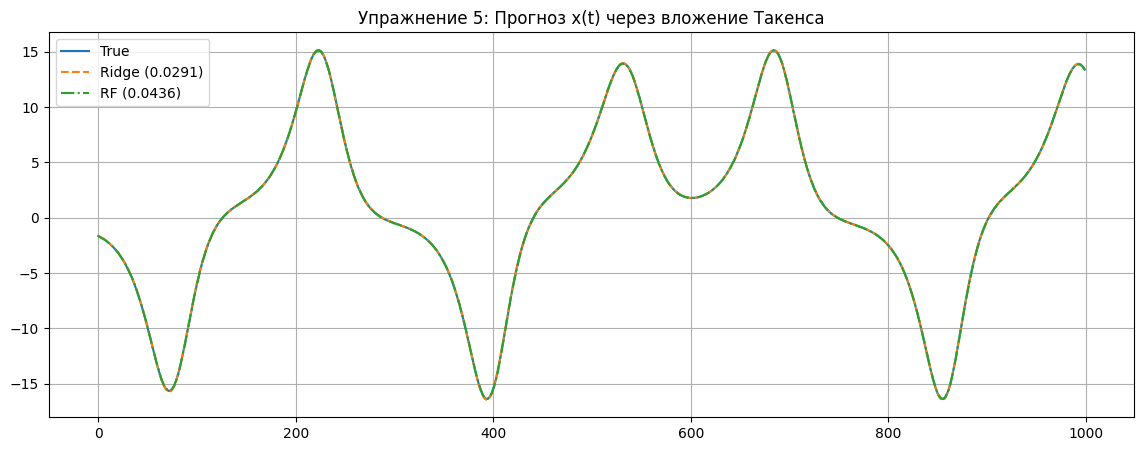

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

sigma, rho, beta = 10.0, 28.0, 8.0 / 3.0
initial_state = [1.0, 1.0, 1.0]
t_eval = np.linspace(0, 50, 10000)

sol = solve_ivp(lorenz, (0, 50), initial_state,
                args=(sigma, rho, beta),
                t_eval=t_eval)

x = sol.y[0]
print("Длина ряда:", len(x))




def takens_embedding(data, delay, dimension):
    N = len(data) - (dimension - 1) * delay
    embedded = np.zeros((N, dimension))
    for i in range(dimension):
        embedded[:, i] = data[i * delay : i * delay + N]
    return embedded

tau = 10
d = 3

X_emb = takens_embedding(x, tau, d)
y_target = x[(d - 1) * tau + 1 : (d - 1) * tau + 1 + len(X_emb)]

min_len = min(len(X_emb), len(y_target))
X_emb = X_emb[:min_len]
y_target = y_target[:min_len]

split = int(0.8 * len(X_emb))
X_train, X_test = X_emb[:split], X_emb[split:]
y_train, y_test = y_target[:split], y_target[split:]


# ===============================
# Ridge
# ===============================

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_s = scaler_X.fit_transform(X_train)
X_test_s = scaler_X.transform(X_test)
y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()

ridge = Ridge(alpha=1e-2)
ridge.fit(X_train_s, y_train_s)

y_pred_ridge = scaler_y.inverse_transform(
    ridge.predict(X_test_s).reshape(-1,1)
).ravel()


# ===============================
# Random Forest
# ===============================

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\n=== Упражнение 5 ===")
print(f"RMSE Ridge: {rmse_ridge:.4f}")
print(f"RMSE Random Forest: {rmse_rf:.4f}")


plt.figure(figsize=(14,5))
n_plot = 1000
plt.plot(y_test[:n_plot], label="True", linewidth=1.5)
plt.plot(y_pred_ridge[:n_plot], '--', label=f"Ridge ({rmse_ridge:.4f})")
plt.plot(y_pred_rf[:n_plot], '-.', label=f"RF ({rmse_rf:.4f})")
plt.legend()
plt.grid(True)
plt.title("Упражнение 5: Прогноз x(t) через вложение Такенса")
plt.show()


### Упражнение 6 

- Вычислите прогнозы переменной состояния $x(t)$ системы Лоренца с помощью ESN, используя горизонт прогнозирования по вашему выбору. 
- Создайте трехмерный график состояний Резервуара, уменьшенный до трех измерений с помощью PCA, и сравните его с реальным аттрактором Лоренца.


=== Упражнение 6 ===
ESN RMSE: 0.0031


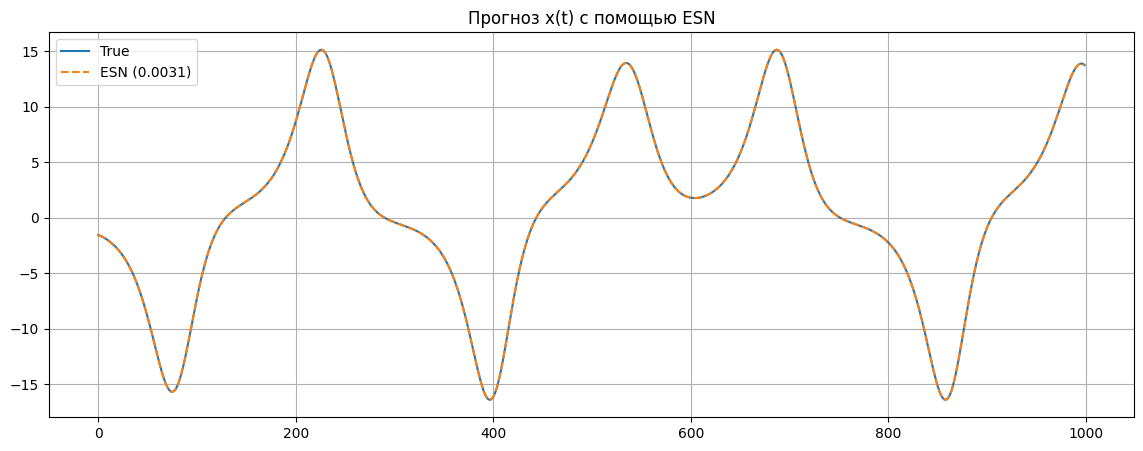

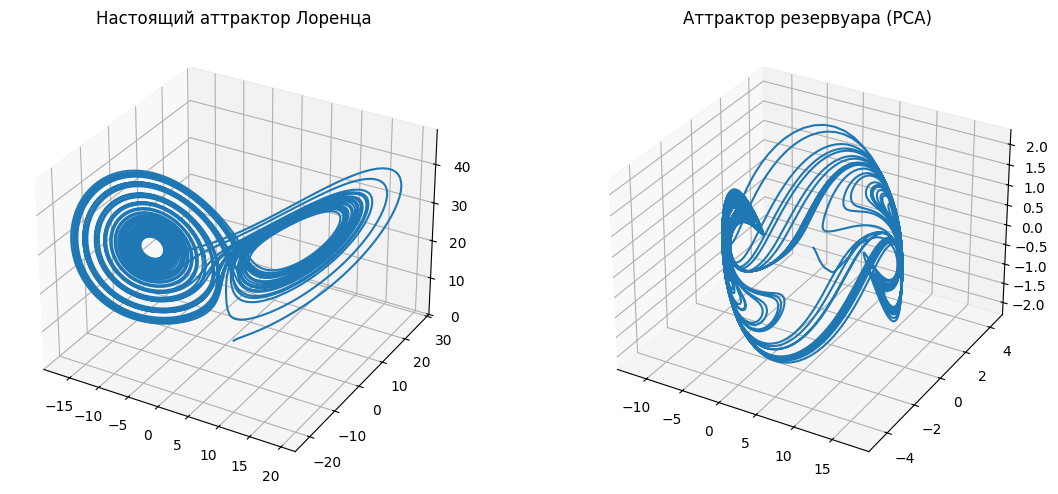

In [37]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

# ===============================
# Простая реализация ESN
# ===============================

class SimpleESN:
    def __init__(self, n_internal_units=500,
                 spectral_radius=0.95,
                 input_scaling=0.1,
                 connectivity=0.1):
        
        self.n_internal_units = n_internal_units
        self.spectral_radius = spectral_radius
        
        self.W = np.random.rand(n_internal_units, n_internal_units) - 0.5
        mask = np.random.rand(*self.W.shape) < connectivity
        self.W *= mask
        
        eigvals = np.linalg.eigvals(self.W)
        self.W *= spectral_radius / np.max(np.abs(eigvals))
        
        self.Win = (np.random.rand(n_internal_units, 1) - 0.5) * input_scaling
        
    def get_states(self, u):
        states = np.zeros((len(u), self.n_internal_units))
        x = np.zeros(self.n_internal_units)
        
        for t in range(len(u)):
            x = np.tanh(self.Win @ [u[t]] + self.W @ x)
            states[t] = x
            
        return states



train_size = int(0.8 * len(x))
x_train = x[:train_size]
x_test = x[train_size:]

horizon = 1

# ===============================
# ESN
# ===============================

esn = SimpleESN(n_internal_units=800,
                spectral_radius=0.99,
                input_scaling=0.1,
                connectivity=0.1)

states_train = esn.get_states(x_train[:-horizon])
states_test = esn.get_states(x_test[:-horizon])

ridge = Ridge(alpha=1e-4)
ridge.fit(states_train, x_train[horizon:])

y_pred_esn = ridge.predict(states_test)
y_true_esn = x_test[horizon:]

rmse_esn = np.sqrt(mean_squared_error(y_true_esn, y_pred_esn))

print("\n=== Упражнение 6 ===")
print(f"ESN RMSE: {rmse_esn:.4f}")


plt.figure(figsize=(14,5))
plt.plot(y_true_esn[:1000], label="True")
plt.plot(y_pred_esn[:1000], '--', label=f"ESN ({rmse_esn:.4f})")
plt.legend()
plt.grid(True)
plt.title("Прогноз x(t) с помощью ESN")
plt.show()




states_full = esn.get_states(x)

pca = PCA(n_components=3)
states_3d = pca.fit_transform(states_full)

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x, sol.y[1], sol.y[2])
ax1.set_title("Настоящий аттрактор Лоренца")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(states_3d[:,0], states_3d[:,1], states_3d[:,2])
ax2.set_title("Аттрактор резервуара (PCA)")

plt.tight_layout()
plt.show()
